In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# IMPORTS
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import joblib
# optional quaternion -> euler converter
try:
    from scipy.spatial.transform import Rotation as R
    _HAS_SCIPY_ROT = True
except Exception:
    _HAS_SCIPY_ROT = False
    print("Warning: scipy.spatial.transform.Rotation not available; quaternion->euler will be skipped.")

In [ ]:
# ---------------- Configuration (your values) ----------------
DATA_DIR = '/content/drive/MyDrive/Hand on ML - Assignemnt/RawData/Dos-Drone'
OUTPUT_DIR = '/content/drive/MyDrive/Hand on ML - Assignemnt/Results'
TARGET_COLUMN = 'Class'
RANDOM_SEED = 42
TEST_RATIO = 0.20
VALIDATION_RATIO = 0.20  # => 60/20/20
np.random.seed(RANDOM_SEED)
os.makedirs(OUTPUT_DIR, exist_ok=True)

### ---------------- Helper functions ----------------

In [ ]:

def safe_to_datetime(series, unit='s'):
    """Try to parse numeric epoch seconds or strings to pandas datetime."""
    try:
        return pd.to_datetime(series.astype(float), unit=unit, errors='coerce')
    except Exception:
        return pd.to_datetime(series, errors='coerce')

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Return distance in meters between coordinate pairs using haversine formula."""
    # handle missing values
    mask = lat1.notnull() & lon1.notnull() & lat2.notnull() & lon2.notnull()
    out = pd.Series(np.nan, index=lat1.index)
    if mask.any():
        lat1r = np.radians(lat1[mask].astype(float))
        lon1r = np.radians(lon1[mask].astype(float))
        lat2r = np.radians(lat2[mask].astype(float))
        lon2r = np.radians(lon2[mask].astype(float))
        dlat = lat2r - lat1r
        dlon = lon2r - lon1r
        a = np.sin(dlat/2)**2 + np.cos(lat1r)*np.cos(lat2r)*np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        R_earth = 6371000.0
        out.loc[mask] = R_earth * c
    return out

In [ ]:
def quaternion_to_euler(df, px='imu-data_orientation.x', py='imu-data_orientation.y', pz='imu-data_orientation.z', pw='imu-data_orientation.w', prefix='imu'):
    """Return DataFrame with roll/pitch/yaw columns if possible (uses scipy Rotation)."""
    if not _HAS_SCIPY_ROT:
        return df
    mask = df[[px, py, pz, pw]].notnull().all(axis=1) if all(c in df.columns for c in [px,py,pz,pw]) else pd.Series(False, index=df.index)
    if not mask.any():
        return df
    arr = df.loc[mask, [px,py,pz,pw]].astype(float).to_numpy()
    r = R.from_quat(arr)  # expects [x, y, z, w]
    euler = r.as_euler('xyz', degrees=True)  # roll, pitch, yaw in degrees
    df.loc[mask, f'{prefix}_roll']  = euler[:, 0]
    df.loc[mask, f'{prefix}_pitch'] = euler[:, 1]
    df.loc[mask, f'{prefix}_yaw']   = euler[:, 2]
    return df

## 1.1 Load and label data

In [ ]:
def load_and_label_data(data_directory):
    all_data = []
    class_mapping = {'normal': 'Normal', 'dos': 'DoS_Attack', 'malfunction': 'Malfunction'}
    for fpath in glob.glob(os.path.join(data_directory, '*.csv')):
        try:
            filename = os.path.basename(fpath).lower()
            class_label = 'Unknown'
            for prefix, label in class_mapping.items():
                if filename.startswith(prefix):
                    class_label = label
                    break
            df = pd.read_csv(fpath)
            df[TARGET_COLUMN] = class_label
            df['Source_File'] = os.path.basename(fpath)
            all_data.append(df)
        except Exception as e:
            print(f"Error loading {fpath}: {e}")
            continue

    if not all_data:
        return pd.DataFrame()
    full_df = pd.concat(all_data, ignore_index=True)
    # Drop file-level S.No if present
    if 'S.No' in full_df.columns:
        full_df.drop('S.No', axis=1, inplace=True)
    print(f"[LOAD] Total dataset shape: {full_df.shape}")
    print(f"[LOAD] Target distribution:\n{full_df[TARGET_COLUMN].value_counts()}")
    return full_df

In [ ]:
df_raw = load_and_label_data(DATA_DIR)
if df_raw.empty:
    raise ValueError("No data loaded. Check DATA_DIR and files.")

# Create flexible lists of time/seq columns
TIME_COLS = [col for col in df_raw.columns if 'time' in col.lower() or 'stamp.secs' in col.lower() or 'stamp' in col.lower()]
SEQUENCE_COLS = [col for col in df_raw.columns if 'seq' in col.lower()]
META_COLS = ['Source_File', TARGET_COLUMN]

# Try to create a unified Timestamp from available columns
timestamp_candidates = ['setpoint_raw-global_Time', 'global_position-local_Time', 'imu-data_Time', 'battery_Time', 'rc-out_Time', 'vfr_hud_Time', 'state_Time', 'RSSI_Time', 'CPU_Time', 'RAM_Time']
found_ts = None
for cand in timestamp_candidates:
    if cand in df_raw.columns:
        found_ts = cand
        break

if found_ts is None:
    # try any column containing 'time' or 'stamp'
    if TIME_COLS:
        found_ts = TIME_COLS[0]
    else:
        raise ValueError("No timestamp column found in dataset.")

print(f"[TIME] Using '{found_ts}' as primary timestamp column.")

[LOAD] Total dataset shape: (87417, 80)
[LOAD] Target distribution:
Class
Normal         49800
DoS_Attack     19587
Malfunction    18030
Name: count, dtype: int64
[TIME] Using 'setpoint_raw-global_Time' as primary timestamp column.


In [ ]:
df_raw['Timestamp'] = safe_to_datetime(df_raw[found_ts], unit='s')
# If conversion failed for many rows, trying no-unit parsing
if df_raw['Timestamp'].isnull().mean() > 0.5:
    df_raw['Timestamp'] = pd.to_datetime(df_raw[found_ts], errors='coerce')

# Drop rows without timestamps
n_before = len(df_raw)
df_raw = df_raw.dropna(subset=['Timestamp'])
print(f"[TIME] Dropped {n_before - len(df_raw)} rows due to missing Timestamp.")
df_raw.set_index('Timestamp', inplace=True)
df_raw.sort_index(inplace=True)

[TIME] Dropped 0 rows due to missing Timestamp.


In [ ]:
# Handle duplicate timestamps by aggregating before resampling
if not df_raw.index.is_unique:
    print("[TIME] Duplicate timestamps found. Aggregating rows with identical timestamps.")

    # Identify numeric and non-numeric columns for aggregation
    numeric_cols_for_agg = df_raw.select_dtypes(include=np.number).columns.tolist()
    non_numeric_cols_for_agg = [col for col in df_raw.columns if col not in numeric_cols_for_agg]

    # creating aggregation dictionary
    agg_dict = {col: 'mean' for col in numeric_cols_for_agg}
    agg_dict.update({col: 'first' for col in non_numeric_cols_for_agg})

    df_raw = df_raw.groupby(level=0).agg(agg_dict)
    df_raw.sort_index(inplace=True) # Sort again after aggregation
    print(f"[TIME] Shape after aggregating duplicate timestamps: {df_raw.shape}")


# Quick dtypes snapshot
print("\n--- Initial Data Types ---")
print(df_raw.dtypes.head(15))
print(f"\nTotal rows: {len(df_raw)}, Total features: {df_raw.shape[1]}")

[TIME] Duplicate timestamps found. Aggregating rows with identical timestamps.
[TIME] Shape after aggregating duplicate timestamps: (84895, 80)

--- Initial Data Types ---
setpoint_raw-global_Time                 float64
setpoint_raw-global_header.seq           float64
setpoint_raw-global_header.stamp.secs    float64
setpoint_raw-global_latitude             float64
setpoint_raw-global_longitude            float64
setpoint_raw-global_altitude             float64
battery_Time                             float64
battery_header.seq                       float64
battery_header.stamp.secs                float64
battery_voltage                          float64
battery_current                          float64
battery_temperature                      float64
battery_percentage                       float64
global_position-local_Time               float64
global_position-local_header.seq         float64
dtype: object

Total rows: 84895, Total features: 80


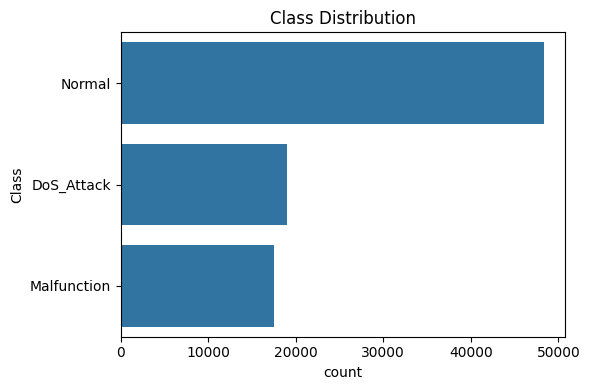

In [ ]:
# Class distribution plot
plt.figure(figsize=(6,4))
sns.countplot(y=TARGET_COLUMN, data=df_raw.reset_index())
plt.title('Class Distribution')
plt.tight_layout()
plt.show()

In [ ]:
df_raw.head(10)

setpoint_raw-global_Time  \
Timestamp                                                 
2024-10-19 05:19:29.000000000              1.729315e+09   
2024-10-19 05:19:29.110145092              1.729315e+09   
2024-10-19 05:19:29.122611761              1.729315e+09   
2024-10-19 05:19:29.122659206              1.729315e+09   
2024-10-19 05:19:29.123682499              1.729315e+09   
2024-10-19 05:19:29.123990297              1.729315e+09   
2024-10-19 05:19:29.124604940              1.729315e+09   
2024-10-19 05:19:29.124633789              1.729315e+09   
2024-10-19 05:19:29.124932051              1.729315e+09   
2024-10-19 05:19:29.125035524              1.729315e+09   

                               setpoint_raw-global_header.seq  \
Timestamp                                                       
2024-10-19 05:19:29.000000000                           797.0   
2024-10-19 05:19:29.110145092                           137.0   
2024-10-19 05:19:29.122611761                           139.0   
2024-10-19 05:19:29.122659206                           141.0   
2024-10-19 05:19:29.123682499                           147.0   
2024-10-19 05:19:29.123990297                           155.0   
2024-10-19 05:19:29.124604940                           170.0   
2024-10-19 05:19:29.124633789                           198.0   
2024-10-19 05:19:29.124932051                           208.0   
2024-10-19 05:19:29.125035524                           214.0   

                               setpoint_raw-global_header.stamp.secs  \
Timestamp                                                              
2024-10-19 05:19:29.000000000                                    0.0   
2024-10-19 05:19:29.110145092                                    0.0   
2024-10-19 05:19:29.122611761                                    0.0   
2024-10-19 05:19:29.122659206                                    0.0   
2024-10-19 05:19:29.123682499                                    0.0   
2024-10-19 05:19:29.123990297                                    0.0   
2024-10-19 05:19:29.124604940                                    0.0   
2024-10-19 05:19:29.124633789                                    0.0   
2024-10-19 05:19:29.124932051                                    0.0   
2024-10-19 05:19:29.125035524                                    0.0   

                               setpoint_raw-global_latitude  \
Timestamp                                                     
2024-10-19 05:19:29.000000000                     33.707308   
2024-10-19 05:19:29.110145092                     33.707308   
2024-10-19 05:19:29.122611761                     33.707308   
2024-10-19 05:19:29.122659206                     33.707308   
2024-10-19 05:19:29.123682499                     33.707308   
2024-10-19 05:19:29.123990297                     33.707308   
2024-10-19 05:19:29.124604940                     33.707308   
2024-10-19 05:19:29.124633789                     33.707308   
2024-10-19 05:19:29.124932051                     33.707308   
2024-10-19 05:19:29.125035524                     33.707308   

                               setpoint_raw-global_longitude  \
Timestamp                                                      
2024-10-19 05:19:29.000000000                      73.019849   
2024-10-19 05:19:29.110145092                      73.019849   
2024-10-19 05:19:29.122611761                      73.019849   
2024-10-19 05:19:29.122659206                      73.019849   
2024-10-19 05:19:29.123682499                      73.019849   
2024-10-19 05:19:29.123990297                      73.019849   
2024-10-19 05:19:29.124604940                      73.019849   
2024-10-19 05:19:29.124633789                      73.019849   
2024-10-19 05:19:29.124932051                      73.019849   
2024-10-19 05:19:29.125035524                      73.019849   

                               setpoint_raw-global_altitude  battery_Time  \
Timestamp                                                                

### 1.2 Missing Data Analysis

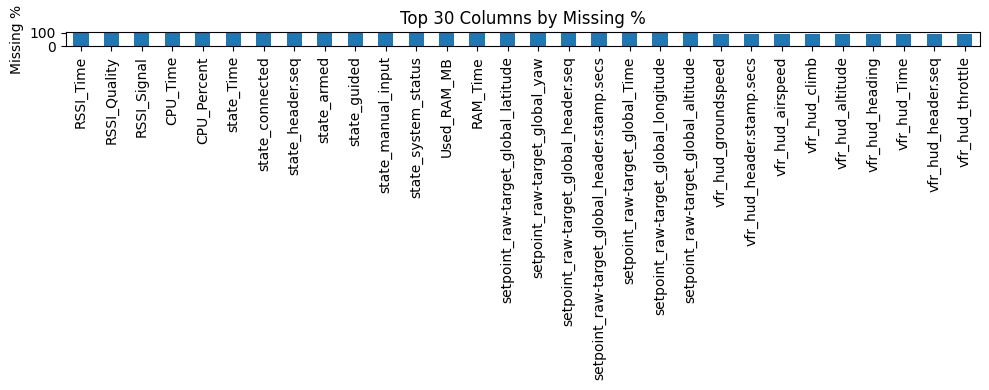

In [ ]:
# Visualizations
plt.figure(figsize=(10,4))
missing_df['MissingPercent'].head(30).plot.bar()
plt.title('Top 30 Columns by Missing %')
plt.ylabel('Missing %')
plt.tight_layout()
plt.show()

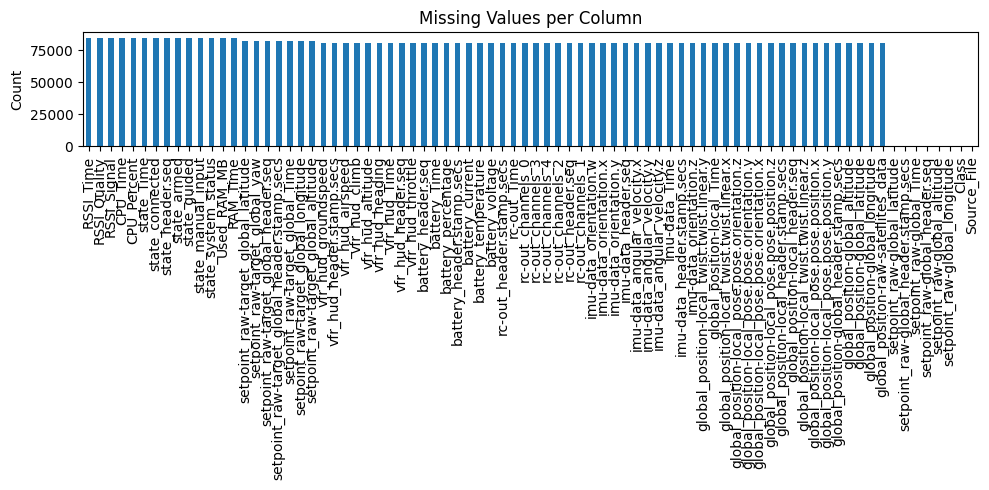

In [ ]:
plt.figure(figsize=(10,5))
df_raw.isnull().sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Missing Values per Column")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# ================================
# CONFIG
# ================================
TARGET_COLUMN = "Class"        # change to "Target" if needed
TIMESTAMP_COL = "Timestamp"   # must exist in raw CSV


# ================================
# 0. ENSURE TIME INDEX
# ================================
# These lines are removed as 'Timestamp' is already the index from previous steps.
# df_raw[TIMESTAMP_COL] = pd.to_datetime(df_raw[TIMESTAMP_COL], errors="coerce")
# df_raw = df_raw.set_index(TIMESTAMP_COL).sort_index()

print("✅ RAW SHAPE:", df_raw.shape)


# ================================
# 1. MISSING VALUE ANALYSIS
# ================================
missing_counts = df_raw.isnull().sum()
missing_pct = 100 * missing_counts / len(df_raw)

missing_df = (
    pd.DataFrame({
        "MissingCount": missing_counts,
        "MissingPercent": missing_pct
    })
    .sort_values("MissingPercent", ascending=False)
)

display(missing_df.head(30))


# ================================
# 2. SAFE COLUMN DROPPING
# ✅ DROP ONLY 100% NaN COLUMNS
# ================================
to_drop_cols = missing_df[missing_df["MissingPercent"] == 100.0].index.tolist()

if to_drop_cols:
    print(f"[SAFE DROP] Dropping {len(to_drop_cols)} fully empty columns.")
    df_raw = df_raw.drop(columns=to_drop_cols)

print("✅ AFTER FULL-NaN DROP SHAPE:", df_raw.shape)


# ================================
# 3. COPY FOR PROCESSING
# ================================
df_proc = df_raw.copy()


# ================================
# 4. IDENTIFY COLUMN TYPES
# ================================

# All numeric columns
numeric_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()

# Numeric features EXCLUDING target
non_target_numeric = [c for c in numeric_cols if c != TARGET_COLUMN]

# State-like + categorical (❌ TARGET EXCLUDED)
bool_like = [
    c for c in df_proc.columns
    if c.lower().startswith("state_") or c == "Source_File"
]

print("✅ NUMERIC COLS:", len(numeric_cols))
print("✅ NON-TARGET NUMERIC:", len(non_target_numeric))
print("✅ BOOL_LIKE:", bool_like)


# ================================
# 5. AGGRESSIVE ROS-SAFE FORWARD FILL
# ✅ NO INTERPOLATION
# ✅ NO TARGET FILL
# ================================

# Forward-fill state/mode flags
if bool_like:
    df_proc[bool_like] = df_proc[bool_like].ffill()

# Forward-fill ALL numeric telemetry (VERY IMPORTANT)
df_proc[non_target_numeric] = df_proc[non_target_numeric].ffill()


# ================================
# 6. FINAL HARD NaN CLEANUP
# ✅ DESTROY ANY ROW THAT STILL HAS NaN
# ================================
df_proc.dropna(axis=0, how="any", inplace=True)
df_proc.dropna(axis=1, how="all", inplace=True)

print("✅ FINAL SHAPE AFTER NaN CLEANUP:", df_proc.shape)
print("✅ FINAL TOTAL NaNs:", df_proc.isnull().sum().sum())


# ================================
# 7. FINAL SANITY CHECKS (MANDATORY)
# ================================
print("✅ FINAL COLUMNS:")
print(df_proc.columns.tolist())

print("\n✅ CLASS DISTRIBUTION:")
print(df_proc[TARGET_COLUMN].value_counts())

print("\n✅ FINAL FEATURE COUNT:",
      len(df_proc.select_dtypes(include=[np.number]).columns) - 1)


✅ RAW SHAPE: (84895, 80)


MissingCount  MissingPercent
RSSI_Time                                            84810       99.899876
RSSI_Quality                                         84810       99.899876
RSSI_Signal                                          84810       99.899876
CPU_Time                                             84713       99.785618
CPU_Percent                                          84713       99.785618
state_Time                                           84430       99.452265
state_connected                                      84430       99.452265
state_header.seq                                     84430       99.452265
state_armed                                          84430       99.452265
state_guided                                         84430       99.452265
state_manual_input                                   84430       99.452265
state_system_status                                  84430       99.452265
Used_RAM_MB                                          84343       99.349785
RAM_Time                                             84343       99.349785
setpoint_raw-target_global_latitude                  82127       96.739502
setpoint_raw-target_global_yaw                       82127       96.739502
setpoint_raw-target_global_header.seq                82127       96.739502
setpoint_raw-target_global_header.stamp.secs         82127       96.739502
setpoint_raw-target_global_Time                      82127       96.739502
setpoint_raw-target_global_longitude                 82127       96.739502
setpoint_raw-target_global_altitude                  82127       96.739502
vfr_hud_groundspeed                                  80637       94.984392
vfr_hud_header.stamp.secs                            80637       94.984392
vfr_hud_airspeed                                     80637       94.984392
vfr_hud_climb                                        80637       94.984392
vfr_hud_altitude                                     80637       94.984392
vfr_hud_heading                                      80637       94.984392
vfr_hud_Time                                         80637       94.984392
vfr_hud_header.seq                                   80637       94.984392
vfr_hud_throttle                                     80637       94.984392

✅ AFTER FULL-NaN DROP SHAPE: (84895, 80)
✅ NUMERIC COLS: 78
✅ NON-TARGET NUMERIC: 78
✅ BOOL_LIKE: ['state_Time', 'state_header.seq', 'state_connected', 'state_armed', 'state_guided', 'state_manual_input', 'state_system_status', 'Source_File']
✅ FINAL SHAPE AFTER NaN CLEANUP: (84894, 80)
✅ FINAL TOTAL NaNs: 0
✅ FINAL COLUMNS:
['setpoint_raw-global_Time', 'setpoint_raw-global_header.seq', 'setpoint_raw-global_header.stamp.secs', 'setpoint_raw-global_latitude', 'setpoint_raw-global_longitude', 'setpoint_raw-global_altitude', 'battery_Time', 'battery_header.seq', 'battery_header.stamp.secs', 'battery_voltage', 'battery_current', 'battery_temperature', 'battery_percentage', 'global_position-local_Time', 'global_position-local_header.seq', 'global_position-local_header.stamp.secs', 'global_position-local_pose.pose.position.x', 'global_position-local_pose.pose.position.y', 'global_position-local_pose.pose.position.z', 'global_position-local_pose.pose.orientation.x', 'global_position-local_pos

In [ ]:
print("Total columns after missing handling:", len(df_proc.columns))
print(df_proc.columns.tolist())
print(df_proc.shape)



Total columns after missing handling: 80
['setpoint_raw-global_Time', 'setpoint_raw-global_header.seq', 'setpoint_raw-global_header.stamp.secs', 'setpoint_raw-global_latitude', 'setpoint_raw-global_longitude', 'setpoint_raw-global_altitude', 'battery_Time', 'battery_header.seq', 'battery_header.stamp.secs', 'battery_voltage', 'battery_current', 'battery_temperature', 'battery_percentage', 'global_position-local_Time', 'global_position-local_header.seq', 'global_position-local_header.stamp.secs', 'global_position-local_pose.pose.position.x', 'global_position-local_pose.pose.position.y', 'global_position-local_pose.pose.position.z', 'global_position-local_pose.pose.orientation.x', 'global_position-local_pose.pose.orientation.y', 'global_position-local_pose.pose.orientation.z', 'global_position-local_twist.twist.linear.x', 'global_position-local_twist.twist.linear.y', 'global_position-local_twist.twist.linear.z', 'imu-data_Time', 'imu-data_header.seq', 'imu-data_header.stamp.secs', 'imu-d

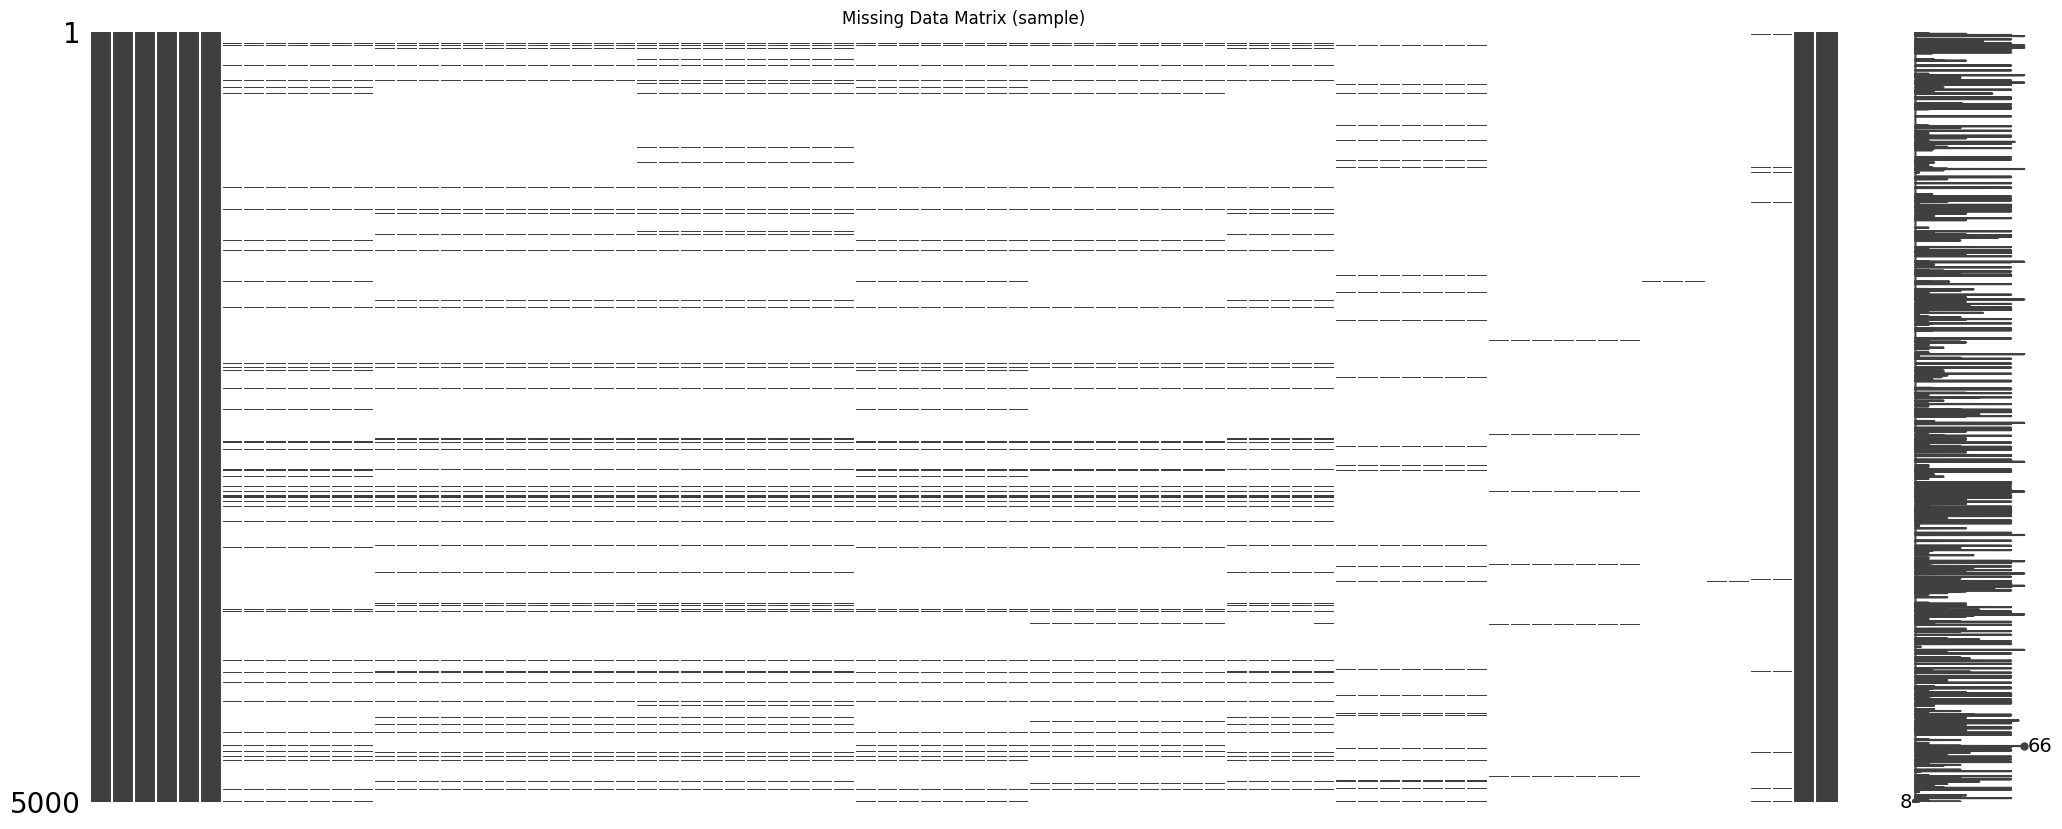

In [ ]:
msno.matrix(df_raw.sample(min(5000, len(df_raw))))
plt.title('Missing Data Matrix (sample)')
plt.show()

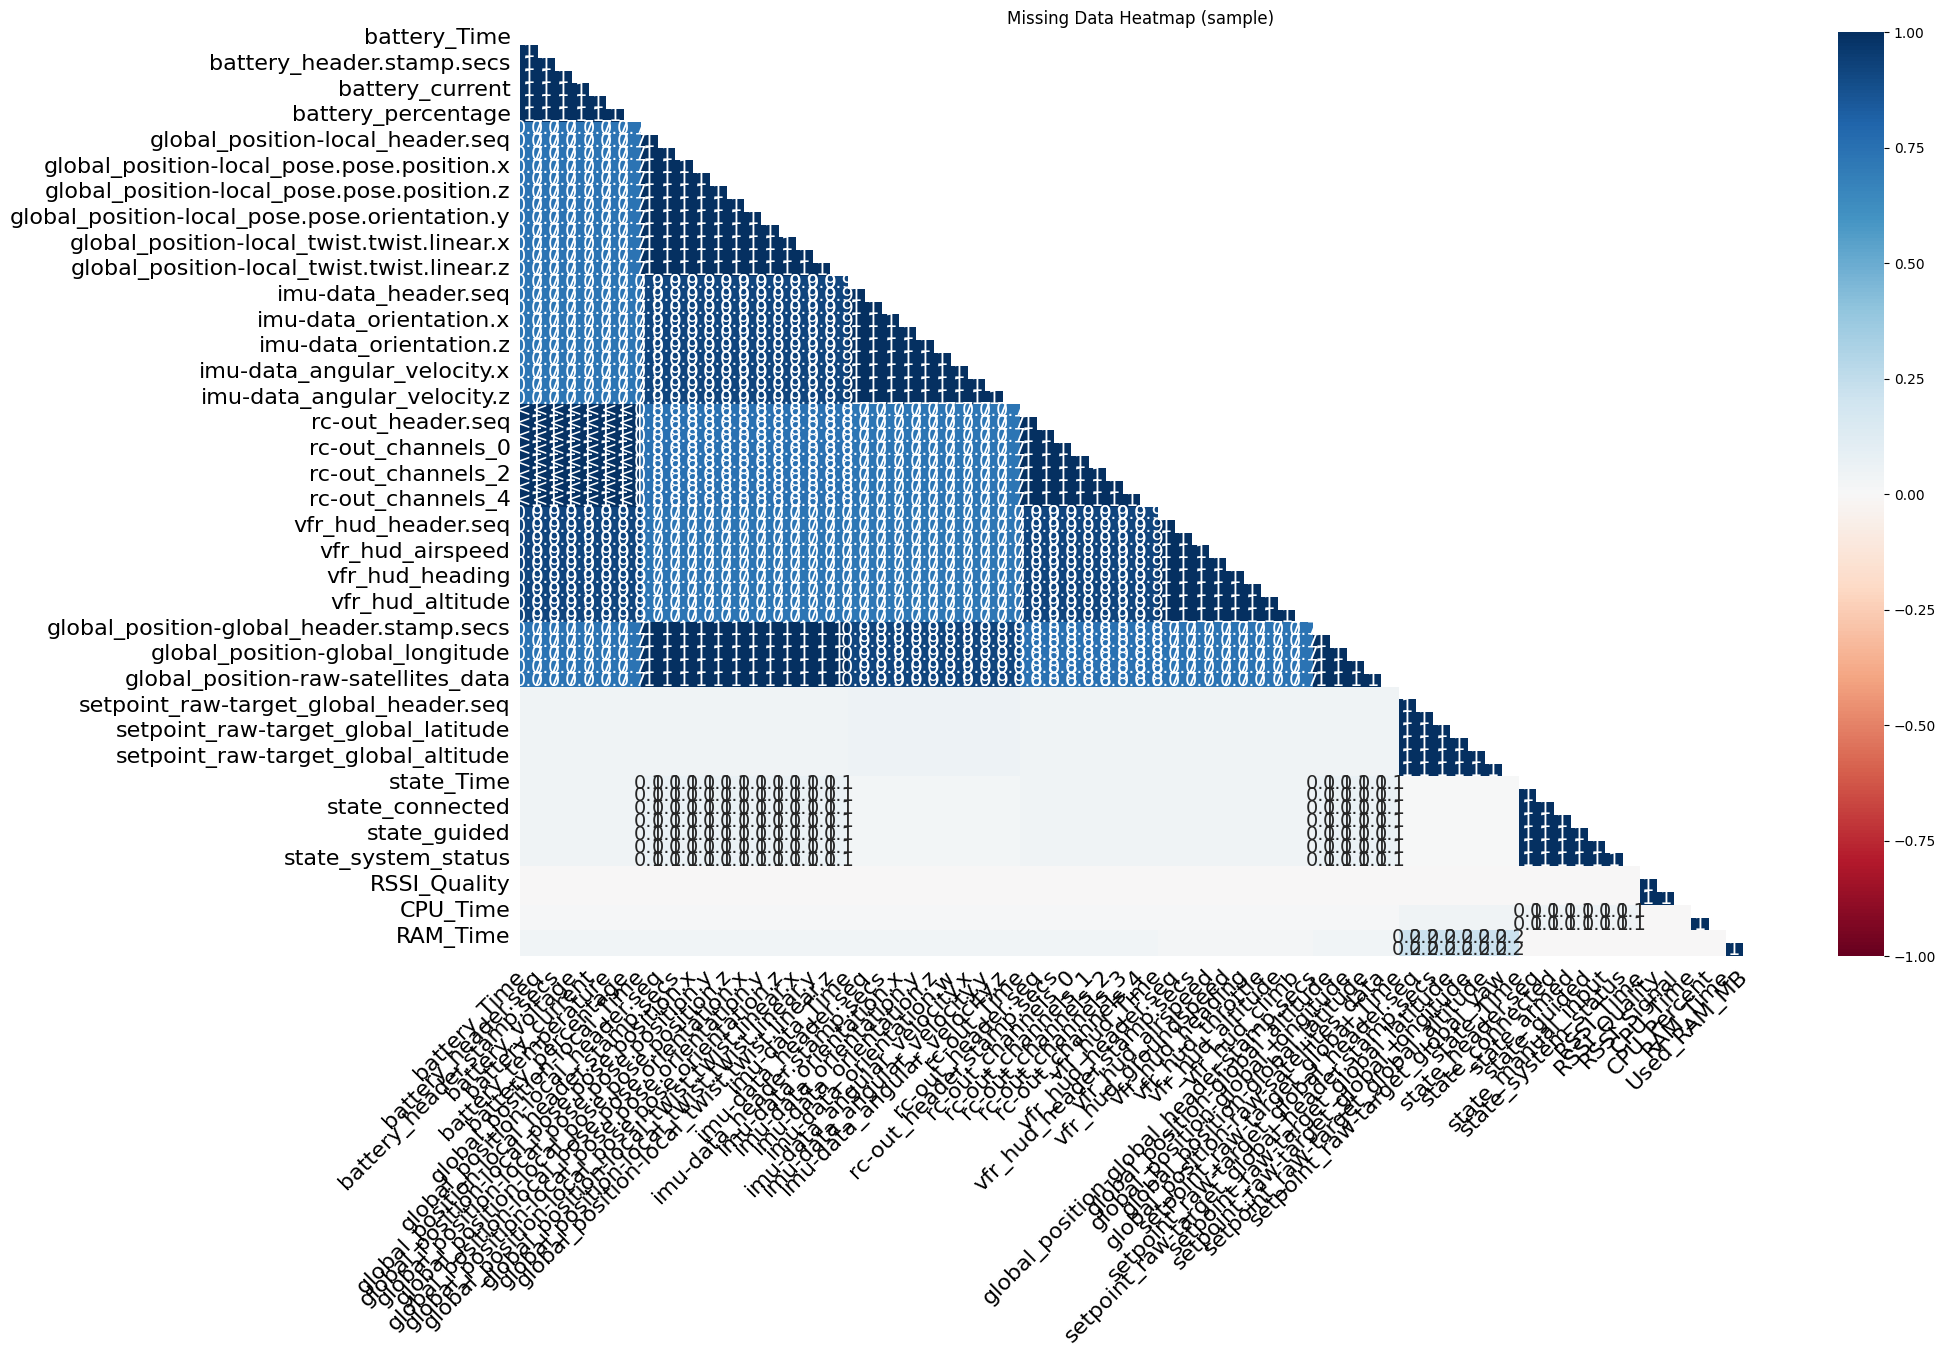

In [ ]:
msno.heatmap(df_raw.sample(min(5000, len(df_raw))))
plt.title('Missing Data Heatmap (sample)')
plt.show()

In [ ]:
df_proc.head(10)

setpoint_raw-global_Time  \
Timestamp                                                 
2024-10-19 05:19:29.110145092              1.729315e+09   
2024-10-19 05:19:29.122611761              1.729315e+09   
2024-10-19 05:19:29.122659206              1.729315e+09   
2024-10-19 05:19:29.123682499              1.729315e+09   
2024-10-19 05:19:29.123990297              1.729315e+09   
2024-10-19 05:19:29.124604940              1.729315e+09   
2024-10-19 05:19:29.124633789              1.729315e+09   
2024-10-19 05:19:29.124932051              1.729315e+09   
2024-10-19 05:19:29.125035524              1.729315e+09   
2024-10-19 05:19:29.125235081              1.729315e+09   

                               setpoint_raw-global_header.seq  \
Timestamp                                                       
2024-10-19 05:19:29.110145092                           137.0   
2024-10-19 05:19:29.122611761                           139.0   
2024-10-19 05:19:29.122659206                           141.0   
2024-10-19 05:19:29.123682499                           147.0   
2024-10-19 05:19:29.123990297                           155.0   
2024-10-19 05:19:29.124604940                           170.0   
2024-10-19 05:19:29.124633789                           198.0   
2024-10-19 05:19:29.124932051                           208.0   
2024-10-19 05:19:29.125035524                           214.0   
2024-10-19 05:19:29.125235081                           229.0   

                               setpoint_raw-global_header.stamp.secs  \
Timestamp                                                              
2024-10-19 05:19:29.110145092                                    0.0   
2024-10-19 05:19:29.122611761                                    0.0   
2024-10-19 05:19:29.122659206                                    0.0   
2024-10-19 05:19:29.123682499                                    0.0   
2024-10-19 05:19:29.123990297                                    0.0   
2024-10-19 05:19:29.124604940                                    0.0   
2024-10-19 05:19:29.124633789                                    0.0   
2024-10-19 05:19:29.124932051                                    0.0   
2024-10-19 05:19:29.125035524                                    0.0   
2024-10-19 05:19:29.125235081                                    0.0   

                               setpoint_raw-global_latitude  \
Timestamp                                                     
2024-10-19 05:19:29.110145092                     33.707308   
2024-10-19 05:19:29.122611761                     33.707308   
2024-10-19 05:19:29.122659206                     33.707308   
2024-10-19 05:19:29.123682499                     33.707308   
2024-10-19 05:19:29.123990297                     33.707308   
2024-10-19 05:19:29.124604940                     33.707308   
2024-10-19 05:19:29.124633789                     33.707308   
2024-10-19 05:19:29.124932051                     33.707308   
2024-10-19 05:19:29.125035524                     33.707308   
2024-10-19 05:19:29.125235081                     33.707308   

                               setpoint_raw-global_longitude  \
Timestamp                                                      
2024-10-19 05:19:29.110145092                      73.019849   
2024-10-19 05:19:29.122611761                      73.019849   
2024-10-19 05:19:29.122659206                      73.019849   
2024-10-19 05:19:29.123682499                      73.019849   
2024-10-19 05:19:29.123990297                      73.019849   
2024-10-19 05:19:29.124604940                      73.019849   
2024-10-19 05:19:29.124633789                      73.019849   
2024-10-19 05:19:29.124932051                      73.019849   
2024-10-19 05:19:29.125035524                      73.019849   
2024-10-19 05:19:29.125235081                      73.019849   

                               setpoint_raw-global_altitude  battery_Time  \
Timestamp                                                                

### 1.3 Outlier Detection & Treatment

In [ ]:
from scipy.stats import zscore

NUM_COLS = df_proc.select_dtypes(include=[np.number]).columns
NUM_COLS = [c for c in NUM_COLS if c != "Class"]

z_outliers = {}
for col in NUM_COLS:
    z = np.abs(zscore(df_proc[col]))
    z_outliers[col] = np.sum(z > 4)

top_outliers = sorted(z_outliers.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Z-score outlier columns:", top_outliers)


Top Z-score outlier columns: [('global_position-local_pose.pose.orientation.y', np.int64(834)), ('imu-data_orientation.y', np.int64(834)), ('imu-data_orientation.x', np.int64(286)), ('global_position-local_pose.pose.orientation.x', np.int64(266)), ('global_position-local_twist.twist.linear.z', np.int64(245)), ('battery_voltage', np.int64(244)), ('vfr_hud_climb', np.int64(235)), ('imu-data_angular_velocity.x', np.int64(222)), ('imu-data_angular_velocity.y', np.int64(209)), ('CPU_Percent', np.int64(201))]


/tmp/ipython-input-3038910024.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z = np.abs(zscore(df_proc[col]))
/tmp/ipython-input-3038910024.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z = np.abs(zscore(df_proc[col]))
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:11002: RuntimeWarning: overflow encountered in multiply
  var = _xp_mean(x_mean * x_mean_conj, keepdims=keepdims, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:11002: RuntimeWarning: overflow encountered in multiply
  var = _xp_mean(x_mean * x_mean_conj, keepdims=keepdims, **kwargs)
/tmp/ipython-input-3038910024.py:8: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This o

IQR Detection(No Capping)

In [ ]:
def iqr_bounds(s):
    Q1, Q3 = s.quantile(0.25), s.quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 1.5*IQR, Q3 + 1.5*IQR

iqr_outliers = {}
for col in NUM_COLS:
    lo, hi = iqr_bounds(df_proc[col])
    iqr_outliers[col] = np.sum((df_proc[col] < lo) | (df_proc[col] > hi))

top_iqr = sorted(iqr_outliers.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top IQR outlier columns:", top_iqr)


Top IQR outlier columns: [('global_position-local_twist.twist.linear.y', np.int64(24290)), ('imu-data_angular_velocity.z', np.int64(23775)), ('global_position-local_twist.twist.linear.x', np.int64(22852)), ('Used_RAM_MB', np.int64(21250)), ('global_position-local_twist.twist.linear.z', np.int64(14123)), ('CPU_Percent', np.int64(14009)), ('rc-out_channels_0', np.int64(13660)), ('rc-out_channels_3', np.int64(13439)), ('vfr_hud_throttle', np.int64(13411)), ('rc-out_channels_2', np.int64(13379))]


For Visualization (BoxPlot)

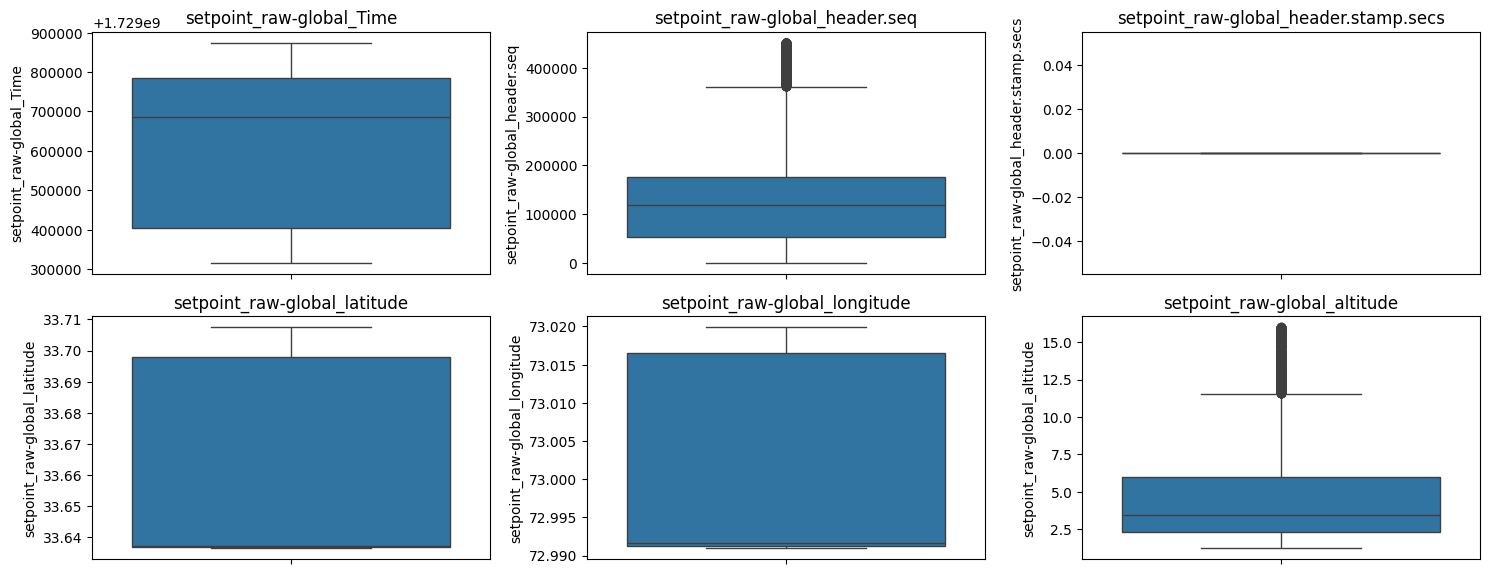

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sample_cols = NUM_COLS[:6]
plt.figure(figsize=(15,6))
for i,c in enumerate(sample_cols):
    plt.subplot(2,3,i+1)
    sns.boxplot(y=df_proc[c])
    plt.title(c)
plt.tight_layout()
plt.show()


Outliers were detected using Z-score and IQR. However, no capping or removal was applied because extreme values correspond to DoS attacks and system malfunctions. Removing them would destroy class separability.

### 1.4 Feature Engineering

In [ ]:
# IMU magnitude
df_proc["imu_ang_vel_mag"] = np.sqrt(
    df_proc["imu-data_angular_velocity.x"]**2 +
    df_proc["imu-data_angular_velocity.y"]**2 +
    df_proc["imu-data_angular_velocity.z"]**2
)

# Linear velocity magnitude
df_proc["lin_vel_mag"] = np.sqrt(
    df_proc["global_position-local_twist.twist.linear.x"]**2 +
    df_proc["global_position-local_twist.twist.linear.y"]**2 +
    df_proc["global_position-local_twist.twist.linear.z"]**2
)

# Battery power
df_proc["battery_power"] = df_proc["battery_voltage"] * df_proc["battery_current"]

# RC control load
rc_cols = [f"rc-out_channels_{i}" for i in range(5)]
df_proc["rc_mean"] = df_proc[rc_cols].mean(axis=1)
df_proc["rc_std"]  = df_proc[rc_cols].std(axis=1)

# GPS drift proxy
df_proc["gps_speed_approx"] = np.sqrt(
    df_proc["global_position-global_latitude"].diff()**2 +
    df_proc["global_position-global_longitude"].diff()**2
).fillna(0)


Physics-consistent derived features (velocity magnitude, battery power, RC load, GPS drift) were added to enhance cyber-physical separability.

### 1.5 Data Normalization / Standardization

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

TARGET = "Class"
feature_cols = [c for c in df_proc.select_dtypes(include=[np.number]).columns if c != TARGET]

X = df_proc[feature_cols].values
y = df_proc[TARGET].astype("category").cat.codes.values

scaler_lstm = StandardScaler()
X_scaled_lstm = scaler_lstm.fit_transform(X)

scaler_svm = RobustScaler()
X_scaled_svm = scaler_svm.fit_transform(X)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1120: RuntimeWarning: overflow encountered in square
  temp **= 2
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


StandardScaler was used for LSTM and VAE to stabilize gradient flow. RobustScaler was used for SVM/XGBoost to reduce sensitivity to heavy-tailed attack features.

### 1.6 Feature Correlation Analysis

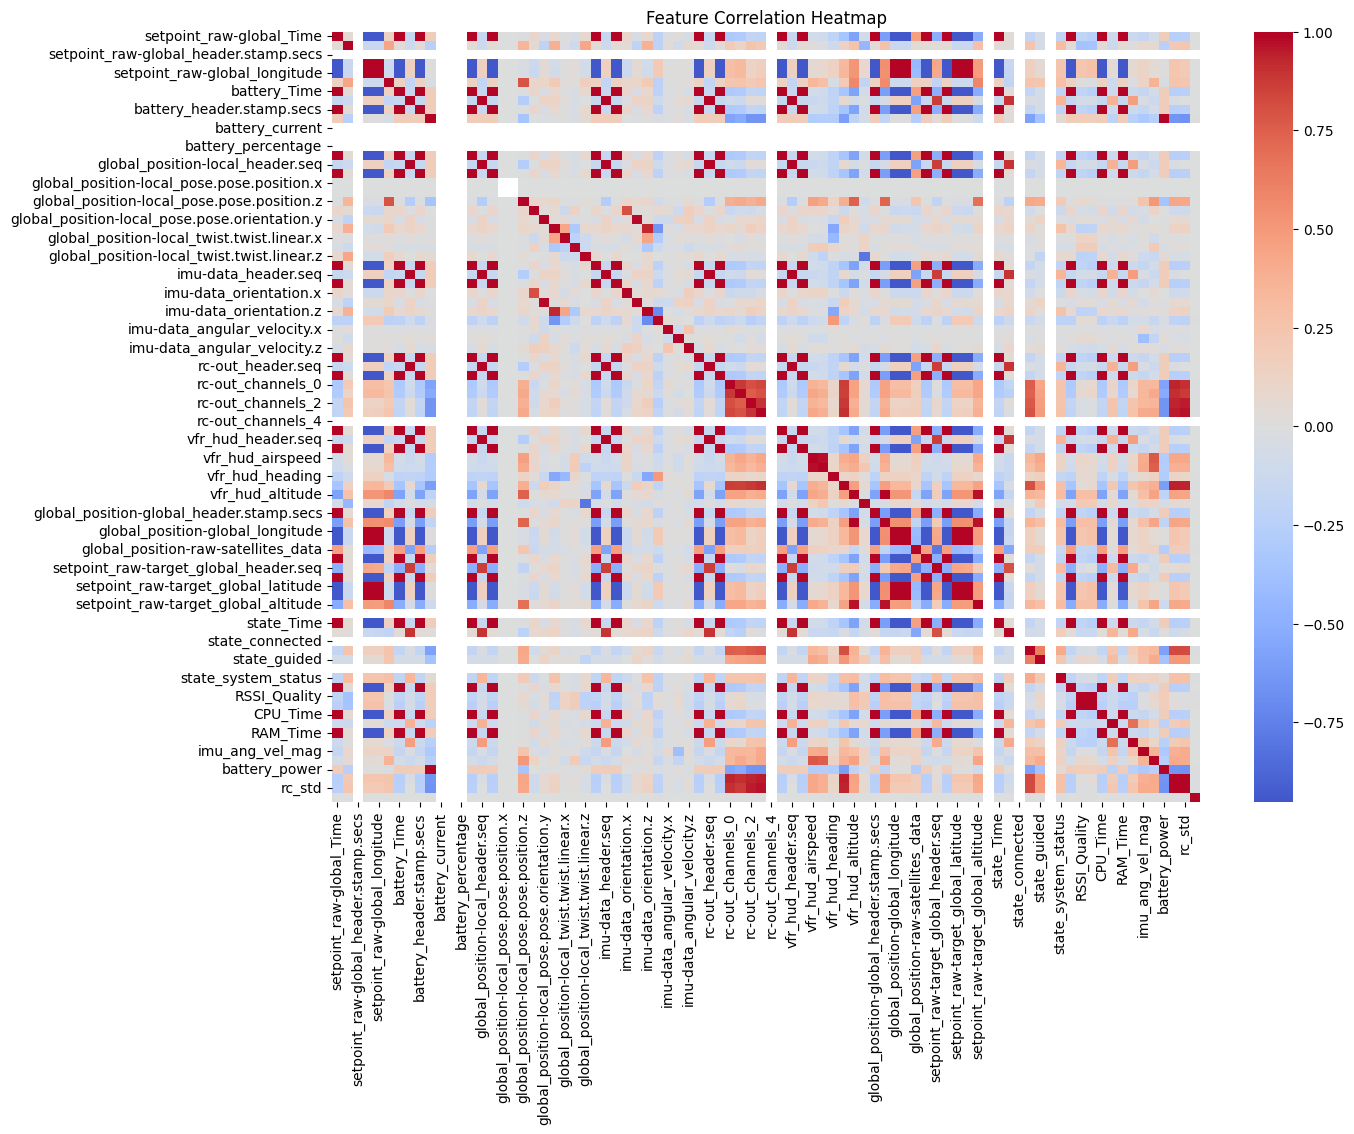

In [ ]:
corr = pd.DataFrame(X_scaled_svm, columns=feature_cols).corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


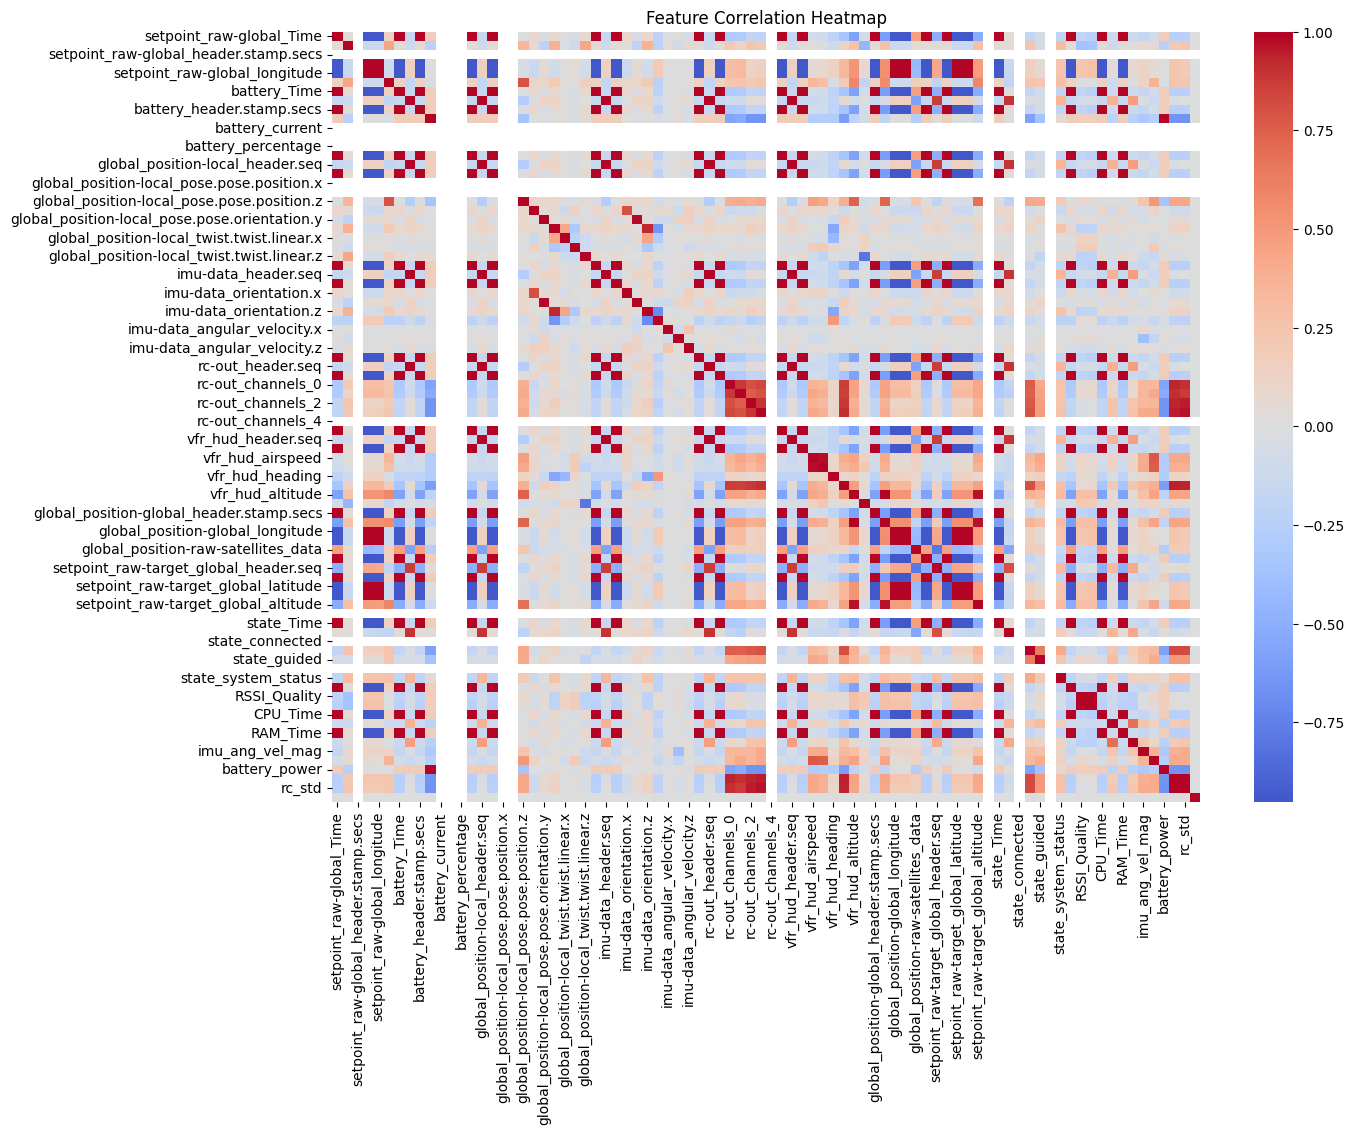

In [ ]:
corr = pd.DataFrame(X_scaled_lstm, columns=feature_cols).corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
HIGH_CORR = 0.95
high_pairs = np.where(np.abs(corr.values) > HIGH_CORR)

redundant = set()
for i,j in zip(*high_pairs):
    if i != j:
        redundant.add((corr.index[i], corr.columns[j]))

print("Highly correlated pairs:", list(redundant)[:10])


Highly correlated pairs: [('vfr_hud_Time', 'battery_header.stamp.secs'), ('setpoint_raw-global_latitude', 'state_Time'), ('global_position-global_latitude', 'RAM_Time'), ('RSSI_Time', 'rc-out_header.stamp.secs'), ('global_position-global_latitude', 'battery_header.stamp.secs'), ('rc_mean', 'rc-out_channels_3'), ('setpoint_raw-target_global_latitude', 'imu-data_header.stamp.secs'), ('CPU_Time', 'global_position-local_Time'), ('setpoint_raw-global_longitude', 'setpoint_raw-target_global_longitude'), ('vfr_hud_header.stamp.secs', 'RSSI_Time')]


If correlation > 0.95 → remove one of the pair for SVM/XGBoost

Keep all for LSTM

### 1.7 Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split

# 60% Train, 40% Temp
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

# 20% Val, 20% Test
X_val_full, X_test_full, y_val_full, y_test_full = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# Convert X splits to DataFrames
X_train_full = pd.DataFrame(X_train_full, columns=feature_cols)
X_val_full   = pd.DataFrame(X_val_full,   columns=feature_cols)
X_test_full  = pd.DataFrame(X_test_full,  columns=feature_cols)


# Convert y splits to Series
y_train_full = pd.Series(y_train_full)
y_val_full   = pd.Series(y_val_full)
y_test_full  = pd.Series(y_test_full)

print("FULL SPLITS")
print("Train:", X_train_full.shape)
print("Val:", X_val_full.shape)
print("Test:", X_test_full.shape)
SAMPLE_FRAC = 0.05
X_train = X_train_full.sample(frac=SAMPLE_FRAC, random_state=42)
y_train = y_train_full.loc[X_train.index]

X_val = X_val_full.sample(frac=SAMPLE_FRAC, random_state=42)
y_val = y_val_full.loc[X_val.index]

X_test = X_test_full.sample(frac=SAMPLE_FRAC, random_state=42)
y_test = y_test_full.loc[X_test.index]


print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

print("\n--- Final Splitting Check ---")
print(f"Train samples (SAMPLED): {len(X_train)}")
print(f"Val samples (SAMPLED): {len(X_val)}")
print(f"Test samples (SAMPLED): {len(X_test)}")
print("\nTrain class distribution:\n", pd.Series(y_train).value_counts(normalize=True).sort_index())
print("\nVal class distribution:\n", pd.Series(y_val).value_counts(normalize=True).sort_index())
print("\nTest class distribution:\n", pd.Series(y_test).value_counts(normalize=True).sort_index())

FULL SPLITS
Train: (50936, 84)
Val: (16979, 84)
Test: (16979, 84)
Train: (2547, 84)
Val:   (849, 84)
Test:  (849, 84)

--- Final Splitting Check ---
Train samples (SAMPLED): 2547
Val samples (FULL): 849
Test samples (FULL): 849

Train class distribution:
 0    0.234001
1    0.191205
2    0.574794
Name: proportion, dtype: float64

Val class distribution:
 0    0.232038
1    0.202591
2    0.565371
Name: proportion, dtype: float64

Test class distribution:
 0    0.235571
1    0.212014
2    0.552415
Name: proportion, dtype: float64


In [ ]:
print("X_final:", X_train.shape)
print("y:", y_train.shape)
print("Class mapping:", dict(enumerate(df_proc[TARGET].astype("category").cat.categories)))
print("Train class distribution:", np.bincount(y_train))
print("Val class distribution:", np.bincount(y_val))
print("Test class distribution:", np.bincount(y_test))



X_final: (2547, 84)
y: (2547,)
Class mapping: {0: 'DoS_Attack', 1: 'Malfunction', 2: 'Normal'}
Train class distribution: [ 596  487 1464]
Val class distribution: [197 172 480]
Test class distribution: [200 180 469]


In [ ]:
# ============================
# VAE NORMAL-ONLY EXTRACTION
# ============================

NORMAL_CLASS = 2   # From your mapping

# --- Extract Normal samples from TRAIN set only ---
X_train_vae = X_train[y_train == NORMAL_CLASS]
X_val_vae   = X_val[y_val == NORMAL_CLASS]   # optional but recommended

print("VAE Train (Normal only):", X_train_vae.shape)
print("VAE Val   (Normal only):", X_val_vae.shape)

# ============================
# SCALING FOR VAE
# ============================

from sklearn.preprocessing import RobustScaler

vae_scaler = RobustScaler()

X_train_vae_scaled = vae_scaler.fit_transform(X_train_vae)
X_val_vae_scaled   = vae_scaler.transform(X_val_vae)

print(" VAE Train Scaled:", X_train_vae_scaled.shape)
print(" VAE Val   Scaled:", X_val_vae_scaled.shape)

VAE Train (Normal only): (1464, 84)
VAE Val   (Normal only): (480, 84)
 VAE Train Scaled: (1464, 84)
 VAE Val   Scaled: (480, 84)


In [ ]:
X_train.head()

setpoint_raw-global_Time  setpoint_raw-global_header.seq  \
33411              1.729406e+09                        197442.0   
2851               1.729315e+09                         93270.0   
29596              1.729874e+09                         29259.0   
19272              1.729688e+09                        133381.0   
39120              1.729686e+09                         49070.0   

       setpoint_raw-global_header.stamp.secs  setpoint_raw-global_latitude  \
33411                                    0.0                     33.697863   
2851                                     0.0                     33.707429   
29596                                    0.0                     33.636580   
19272                                    0.0                     33.637118   
39120                                    0.0                     33.637084   

       setpoint_raw-global_longitude  setpoint_raw-global_altitude  \
33411                      73.016577                         6.352   
2851                       73.019737                         3.715   
29596                      72.991520                         3.117   
19272                      72.991306                         3.269   
39120                      72.991251                         3.115   

       battery_Time  battery_header.seq  battery_header.stamp.secs  \
33411  1.729406e+09              8729.0               1.729406e+09   
2851   1.729315e+09             15092.0               1.729315e+09   
29596  1.729874e+09              8650.0               1.729874e+09   
19272  1.729688e+09             21588.0               1.729688e+09   
39120  1.729686e+09               202.0               1.729686e+09   

       battery_voltage  ...      CPU_Time  CPU_Percent      RAM_Time  \
33411            0.036  ...  1.729406e+09          1.5  1.729406e+09   
2851             0.165  ...  1.729315e+09         10.2  1.729315e+09   
29596            0.119  ...  1.729874e+09         11.0  1.729874e+09   
19272            0.017  ...  1.729688e+09         39.4  1.729688e+09   
39120            0.024  ...  1.729686e+09         25.1  1.729686e+09   

       Used_RAM_MB  imu_ang_vel_mag  lin_vel_mag  battery_power  rc_mean  \
33411         39.0         0.527505     0.353977        0.00036   1322.8   
2851           5.9         0.003187     0.053852        0.00165    800.0   
29596          5.5         0.348955     0.203961        0.00119   1276.8   
19272         36.7         0.079062     0.228692        0.00017   1266.0   
39120          5.7         0.718346     1.183469        0.00024   1269.4   

           rc_std  gps_speed_approx  
33411  745.241370      5.385165e-07  
2851   447.213595      0.000000e+00  
29596  742.409388      0.000000e+00  
19272  727.768851      0.000000e+00  
39120  712.442840      0.000000e+00  

[5 rows x 84 columns]

In [ ]:
import joblib
import os

SAVE_DIR = "/content/drive/MyDrive/Hand on ML - Assignemnt/ProcessedData"
os.makedirs(SAVE_DIR, exist_ok=True)

# -------------------------
# Save SVM / XGBoost data
# -------------------------
joblib.dump(X_train, f"{SAVE_DIR}/X_train.pkl")
joblib.dump(y_train, f"{SAVE_DIR}/y_train.pkl")

joblib.dump(X_val,   f"{SAVE_DIR}/X_val.pkl")
joblib.dump(y_val,   f"{SAVE_DIR}/y_val.pkl")

joblib.dump(X_test,  f"{SAVE_DIR}/X_test.pkl")
joblib.dump(y_test,  f"{SAVE_DIR}/y_test.pkl")

# -------------------------
# Save VAE Normal-only data
# -------------------------
joblib.dump(X_train_vae_scaled, f"{SAVE_DIR}/X_train_vae.pkl")
joblib.dump(X_val_vae_scaled,   f"{SAVE_DIR}/X_val_vae.pkl")

# -------------------------
# Save Scalers
# -------------------------
joblib.dump(vae_scaler, f"{SAVE_DIR}/vae_scaler.pkl")

# If you already created these earlier:
joblib.dump(X_scaled_svm,  f"{SAVE_DIR}/X_scaled_svm.pkl")
joblib.dump(X_scaled_lstm, f"{SAVE_DIR}/X_scaled_lstm.pkl")

# -------------------------
# Save Feature Names + Class Mapping
# -------------------------
joblib.dump(feature_cols, f"{SAVE_DIR}/feature_cols.pkl")

class_mapping = dict(enumerate(df_proc[TARGET].astype("category").cat.categories))
joblib.dump(class_mapping, f"{SAVE_DIR}/class_mapping.pkl")

print("✅ ALL PROCESSED DATA SAVED SUCCESSFULLY")


✅ ALL PROCESSED DATA SAVED SUCCESSFULLY


# Data Visualization


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

# ---------------- choose dataset for EDA ----------------
# Use the df_proc already prepared in the preprocessing steps
# df_proc = df_proc.copy() # Optional, if you want a fresh copy for EDA modifications
# TARGET_COLUMN is already defined globally as 'Class', but re-assigning for clarity in this section
TARGET_COLUMN = "Class"

numeric_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != TARGET_COLUMN]

# --- Global Cleaning for all numeric_cols in df_proc ---
for col in numeric_cols:
    # Ensure the series is numeric. Coerce errors will turn non-numeric into NaN.
    df_proc[col] = pd.to_numeric(df_proc[col], errors='coerce')

    # Replace infinite values with NaN
    if df_proc[col].isin([np.inf, -np.inf]).any():
        df_proc[col].replace([np.inf, -np.inf], np.nan, inplace=True)

    # Impute remaining NaN values with the median
    if df_proc[col].isnull().any():
        median_val = df_proc[col].median()
        # Fallback if median calculation itself fails (e.g., if all values became NaN)
        if pd.isna(median_val):
            print(f"Warning: Median for column '{col}' is NaN. Filling with 0 as a last resort.")
            df_proc[col].fillna(0, inplace=True) # Fallback to 0 if median is also NaN
        else:
            df_proc[col].fillna(median_val, inplace=True)

    # Final check for non-finite values (should ideally be empty)
    if not np.isfinite(df_proc[col]).all():
        print(f"Error: Column '{col}' still contains non-finite values after all cleaning steps.")


## 1. Distribution plots (Histograms + KDE)

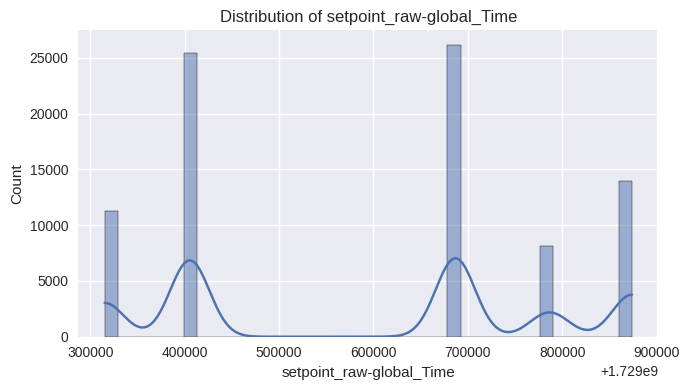

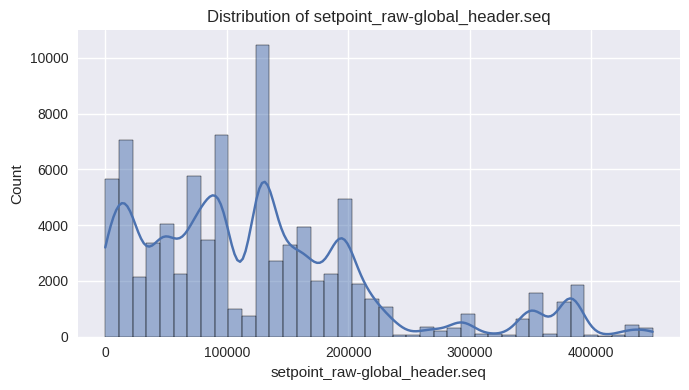

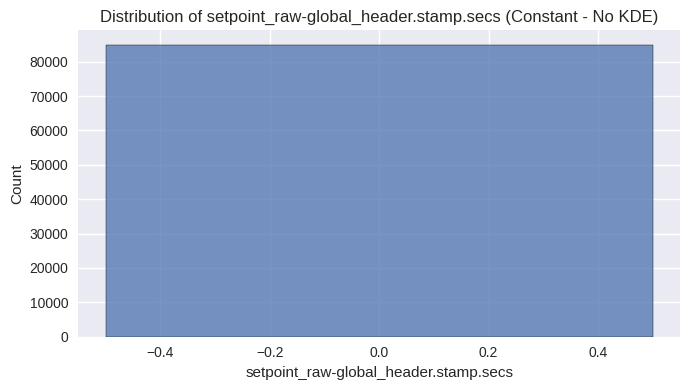

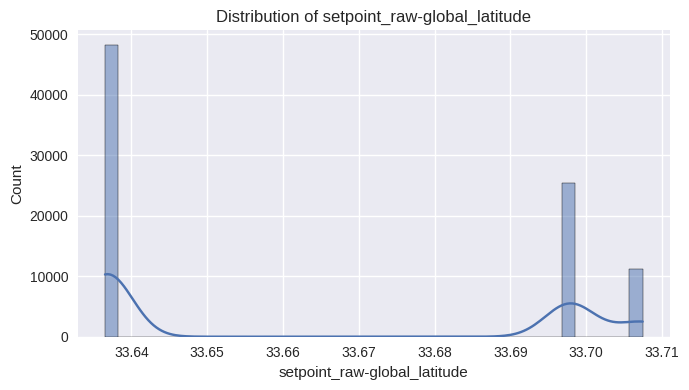

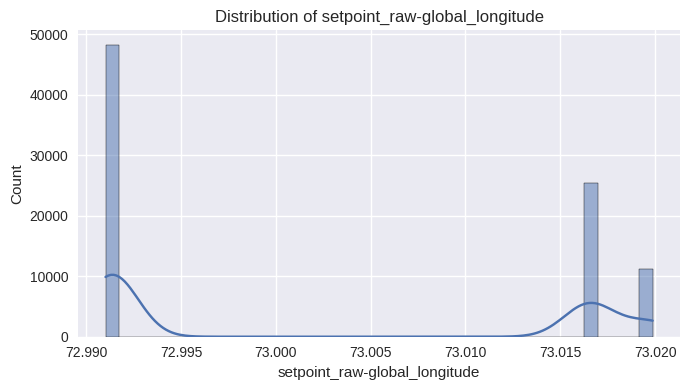

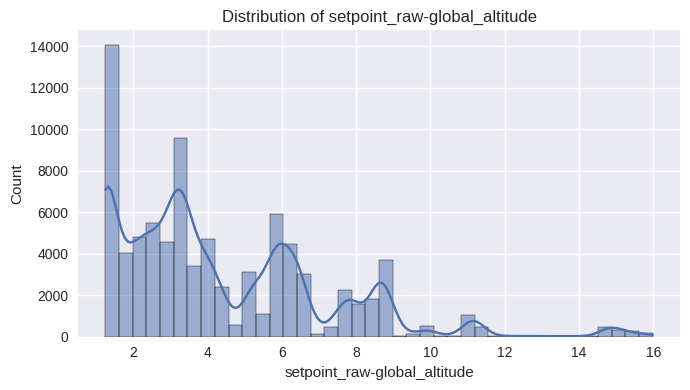

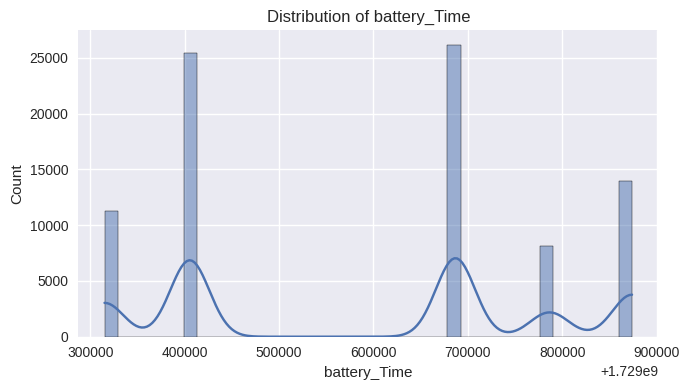

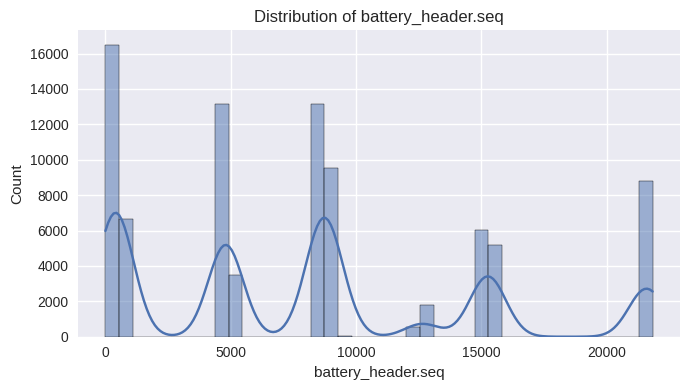

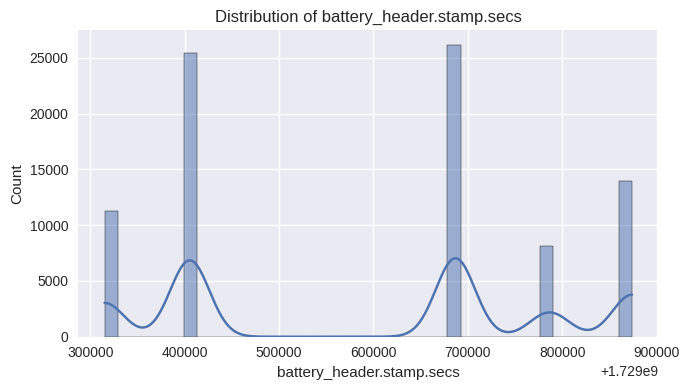

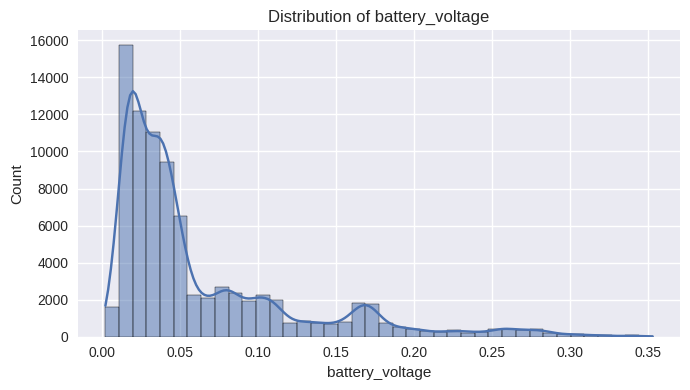

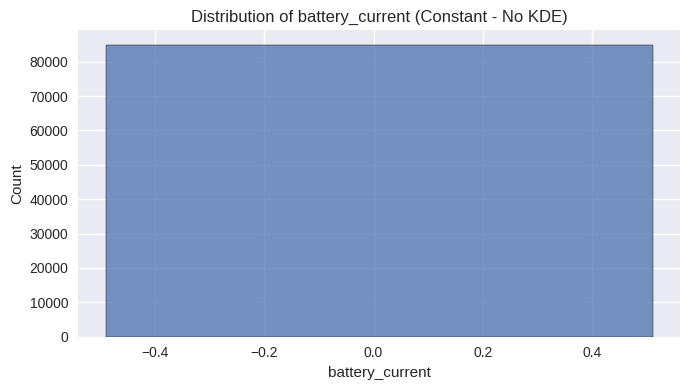

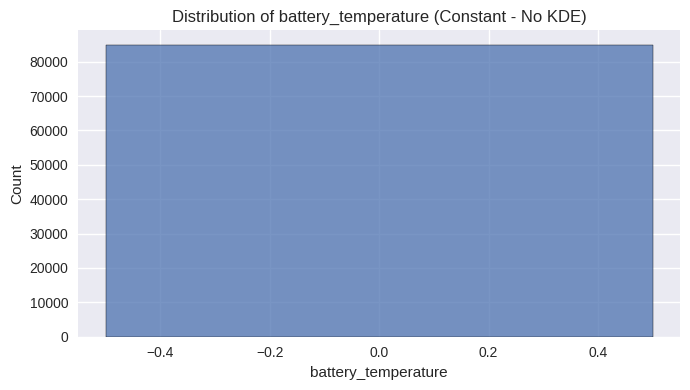

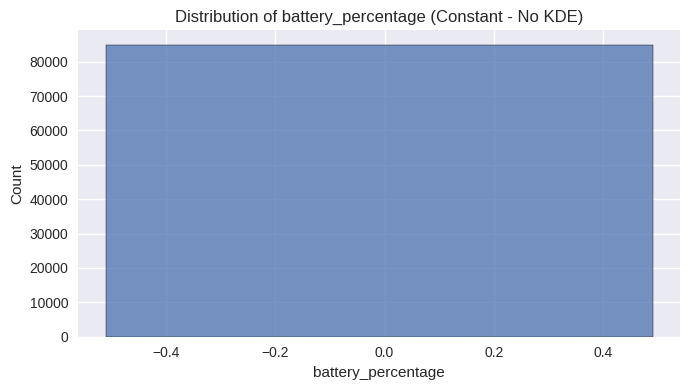

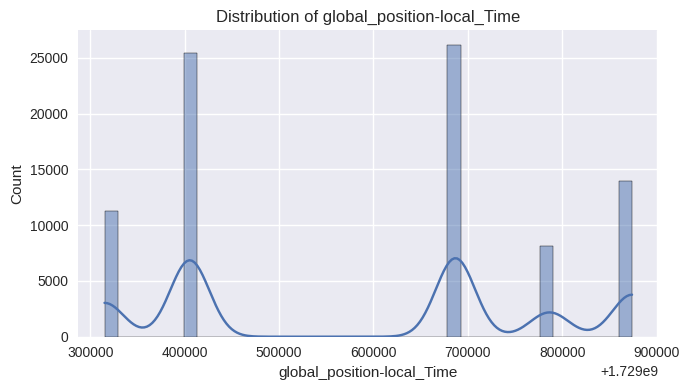

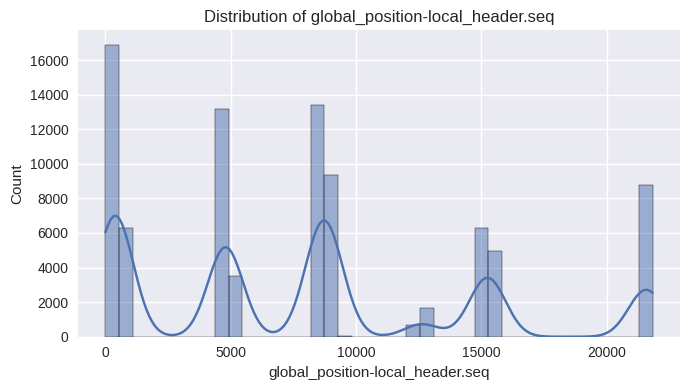

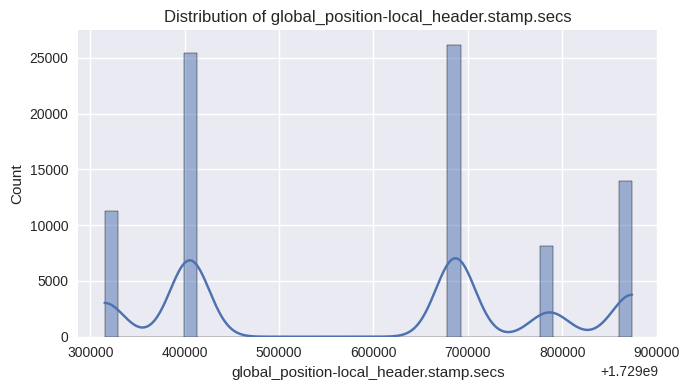

/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


Unexpected error plotting column 'global_position-local_pose.pose.position.x' with KDE: array must not contain infs or NaNs. Plotting histogram without KDE as a fallback.


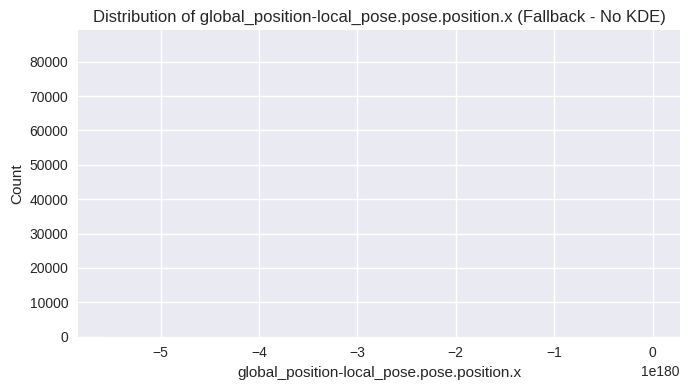

/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


Unexpected error plotting column 'global_position-local_pose.pose.position.y' with KDE: array must not contain infs or NaNs. Plotting histogram without KDE as a fallback.


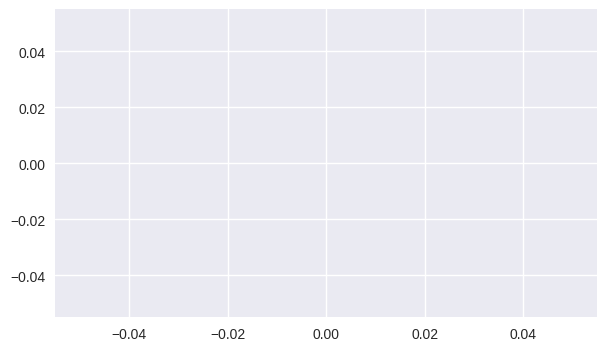

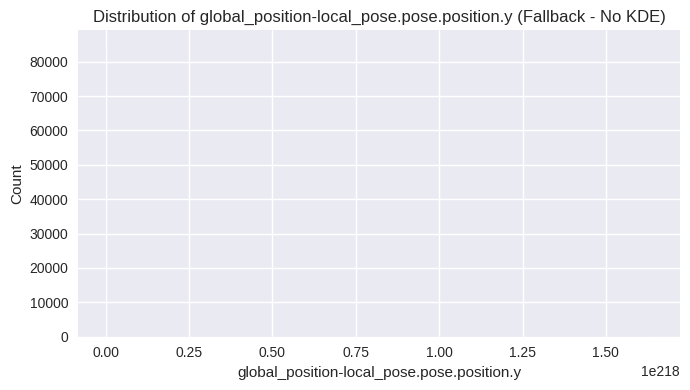

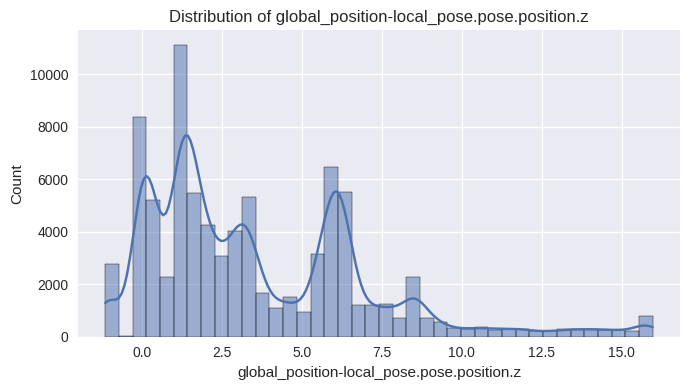

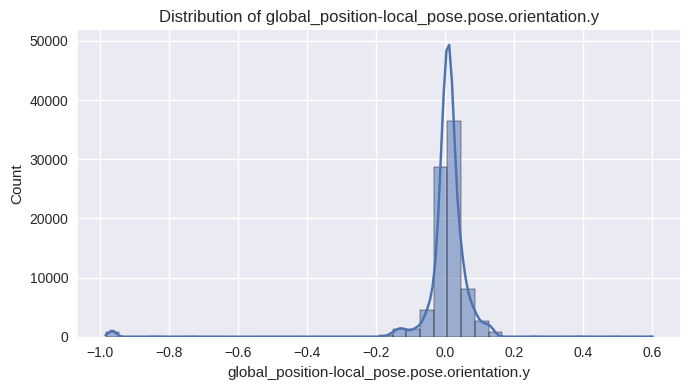

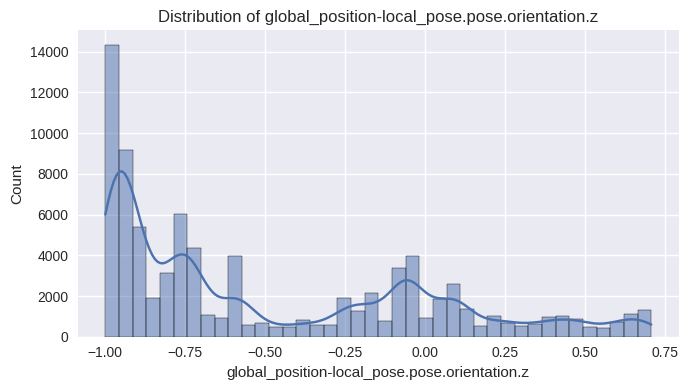

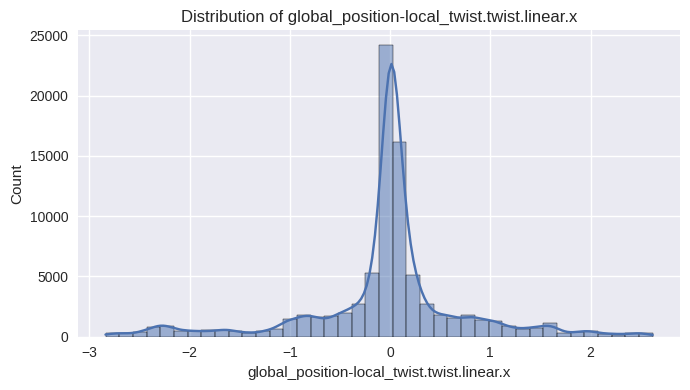

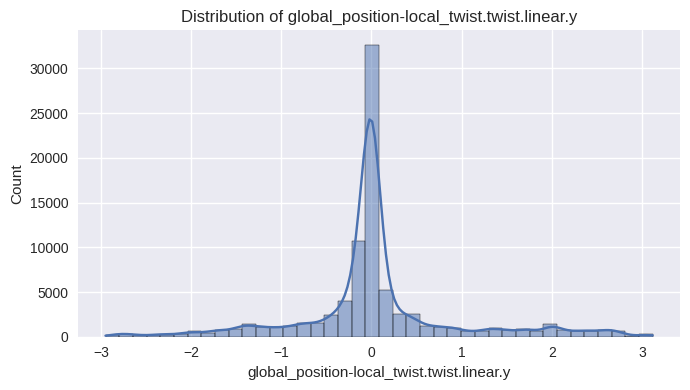

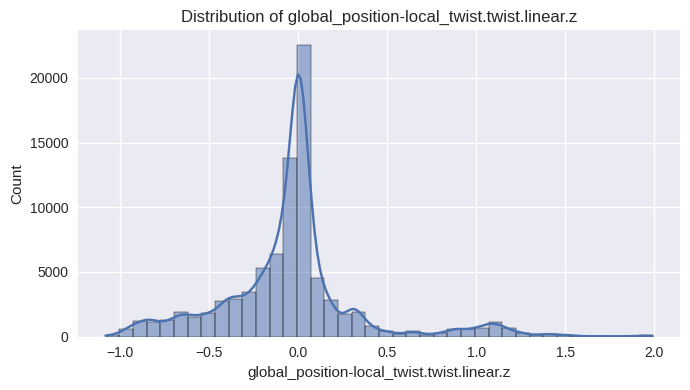

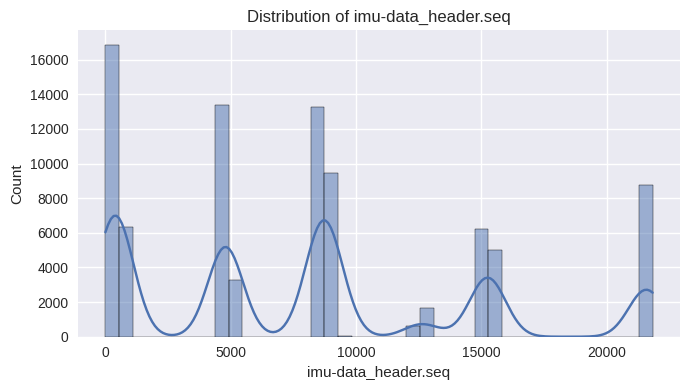

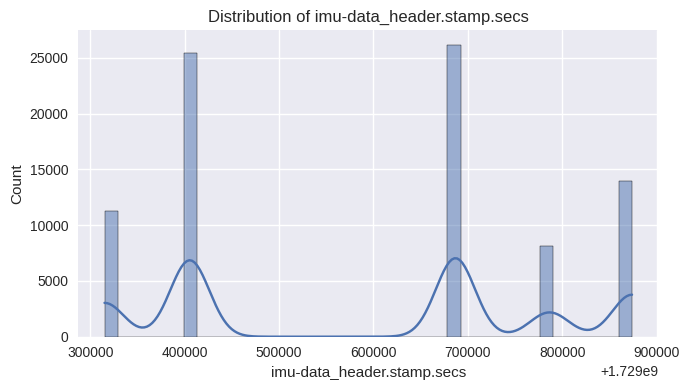

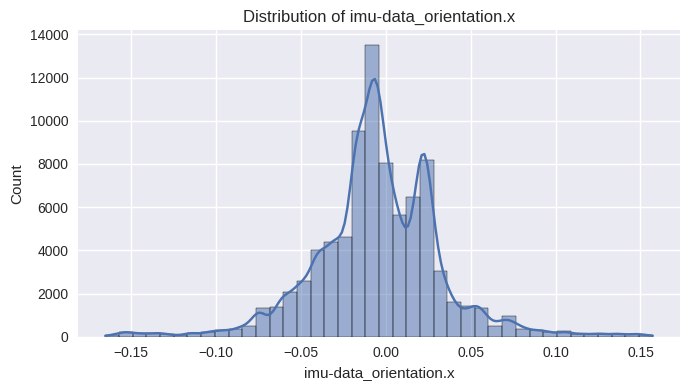

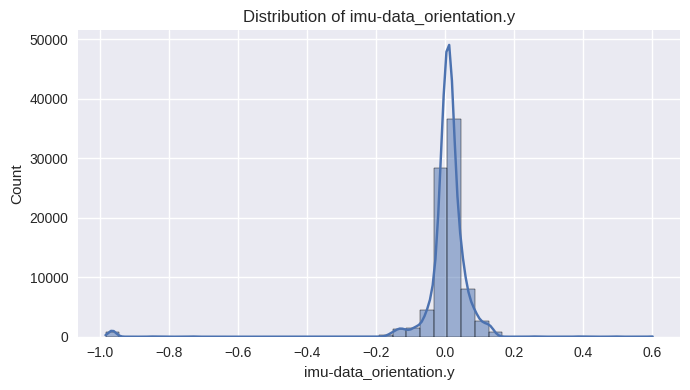

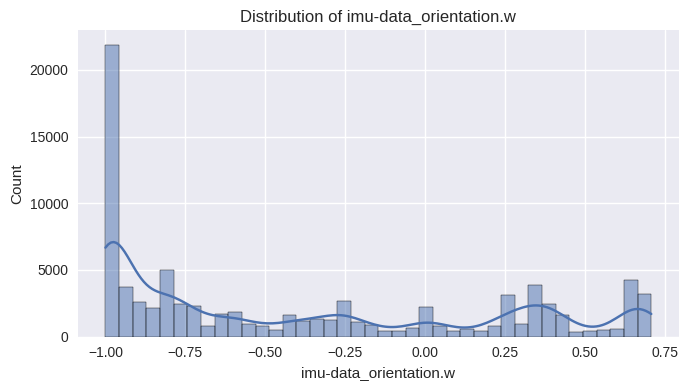

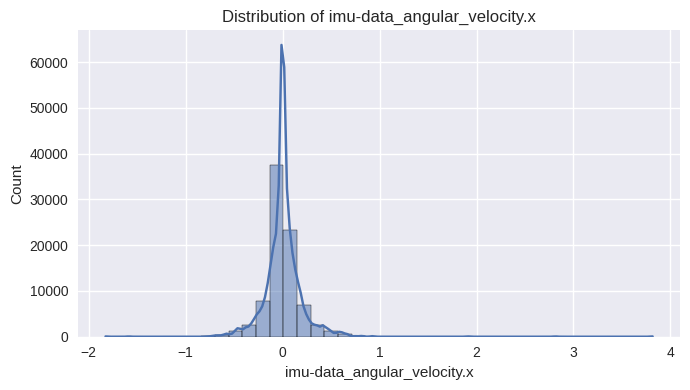

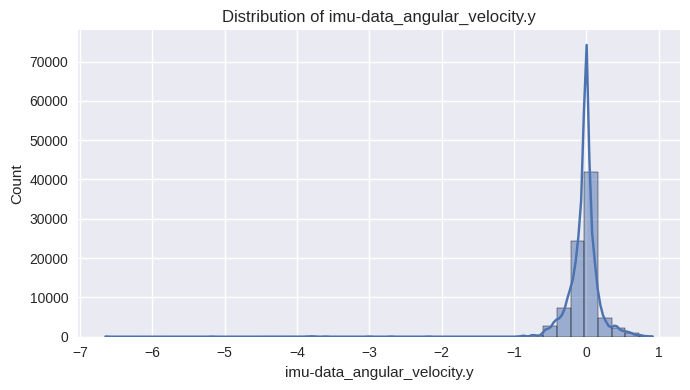

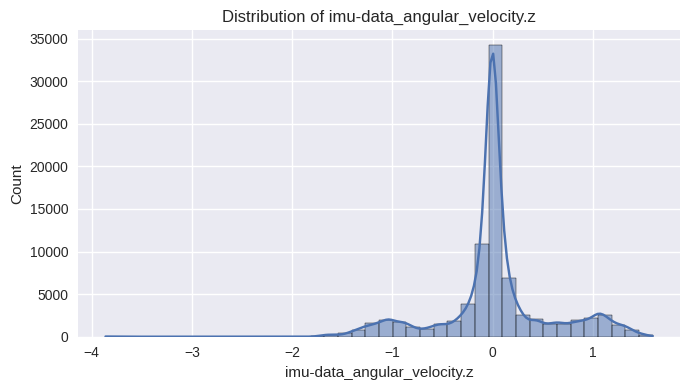

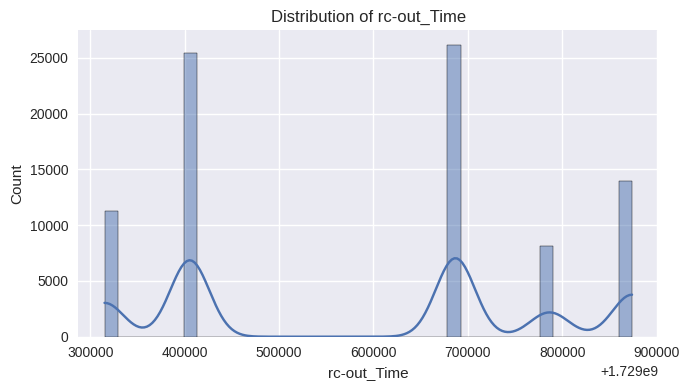

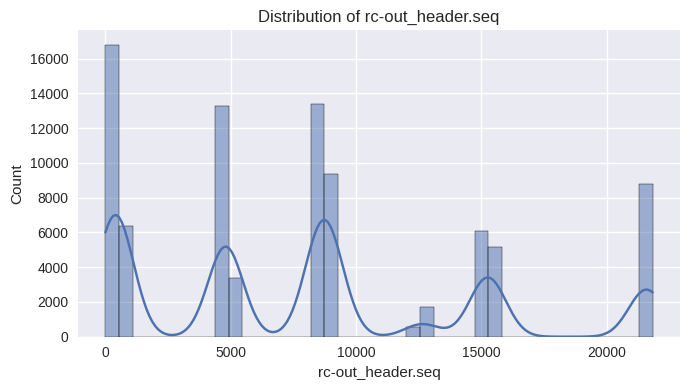

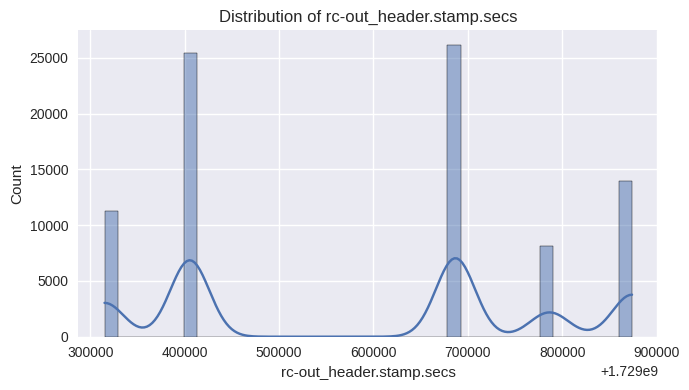

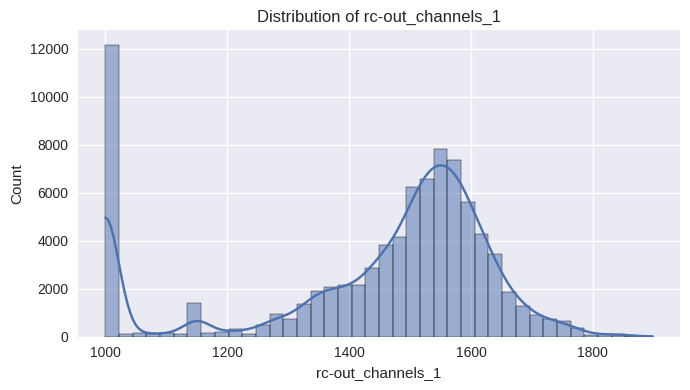

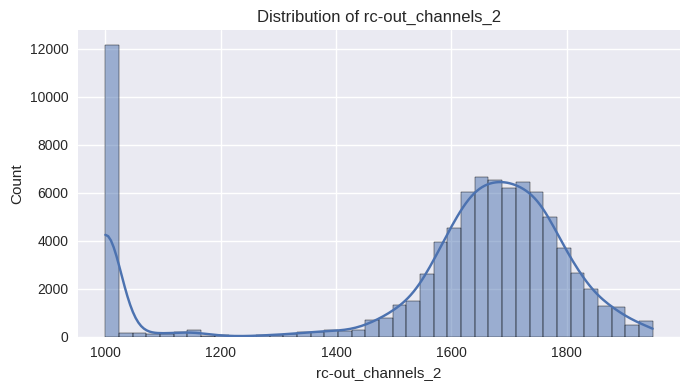

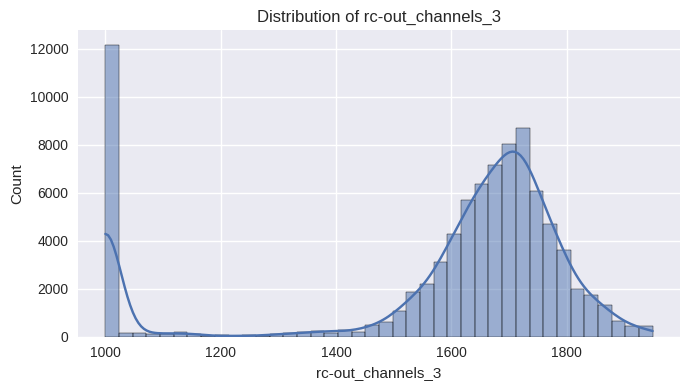

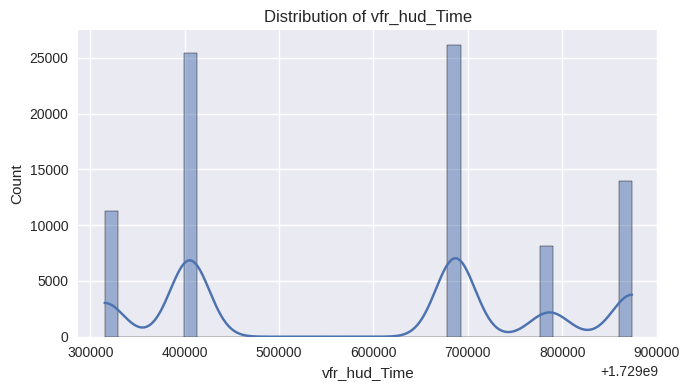

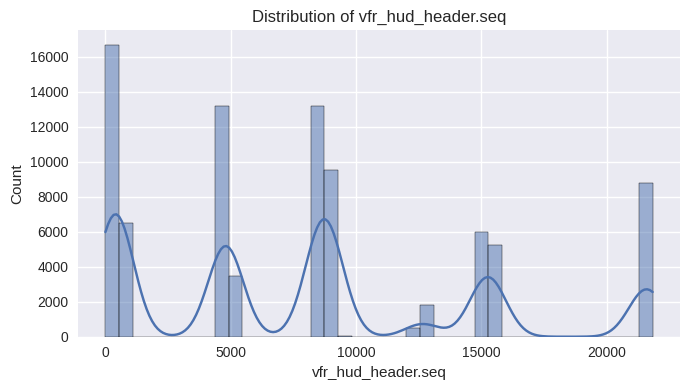

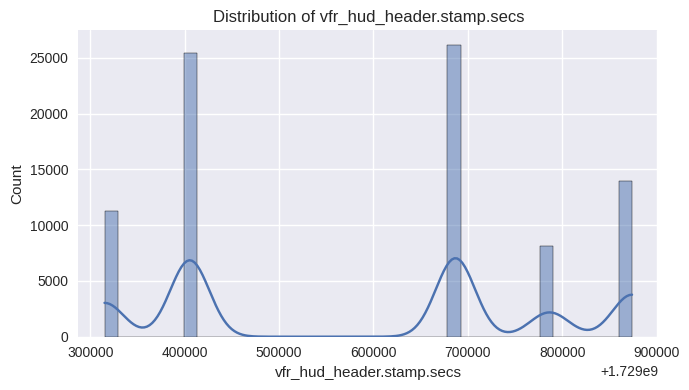

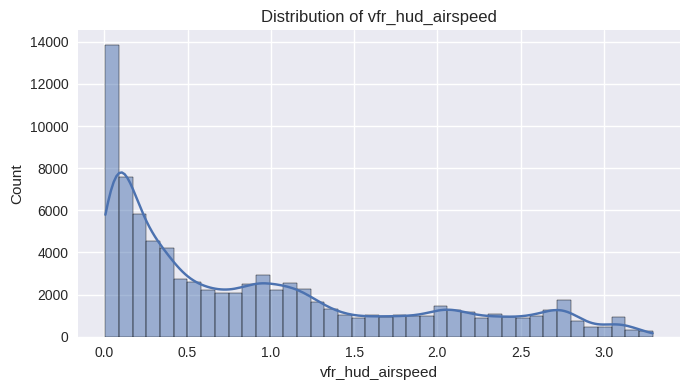

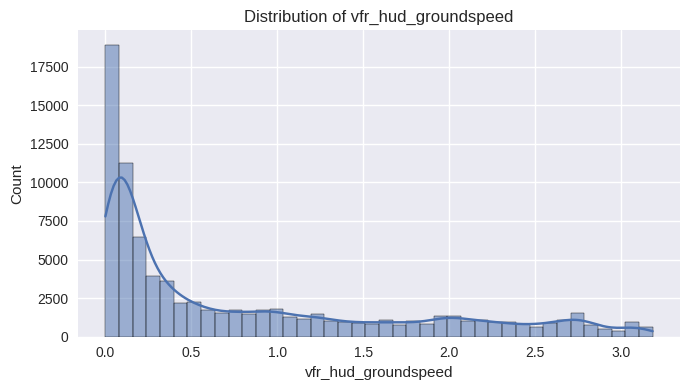

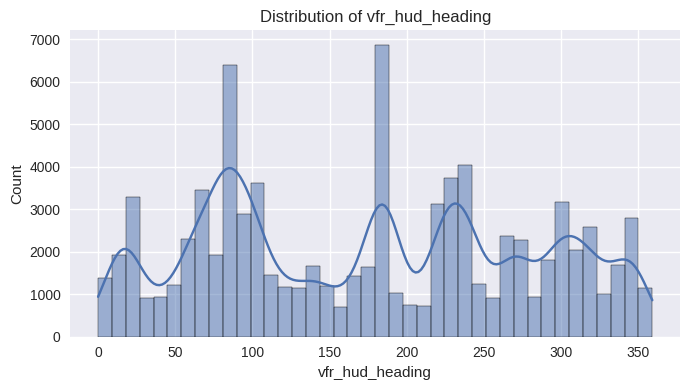

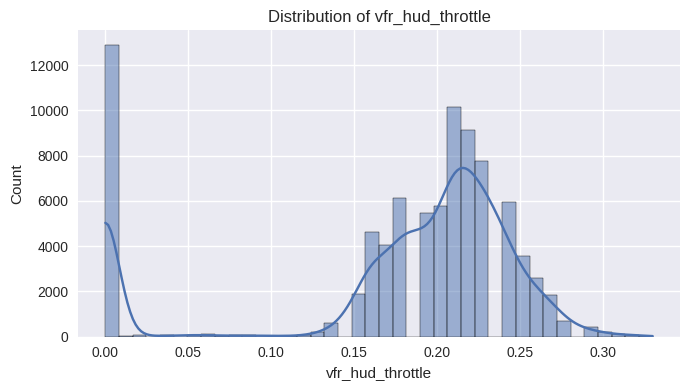

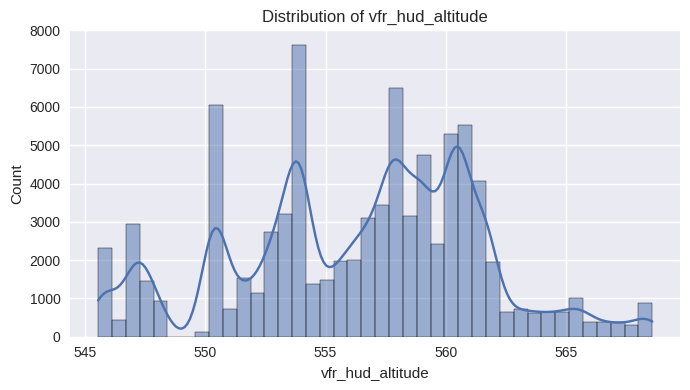

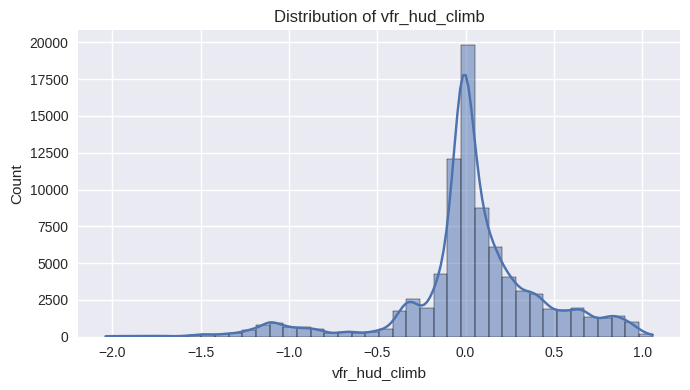

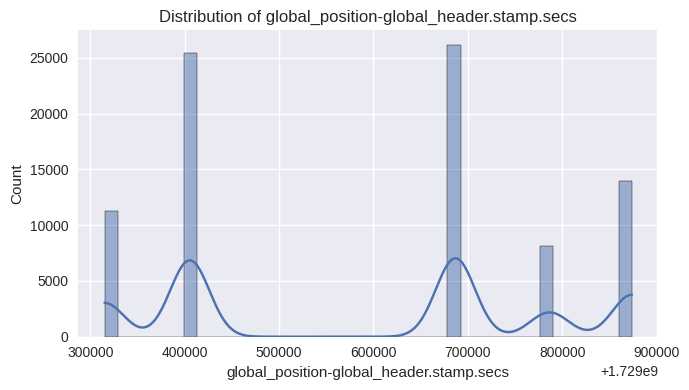

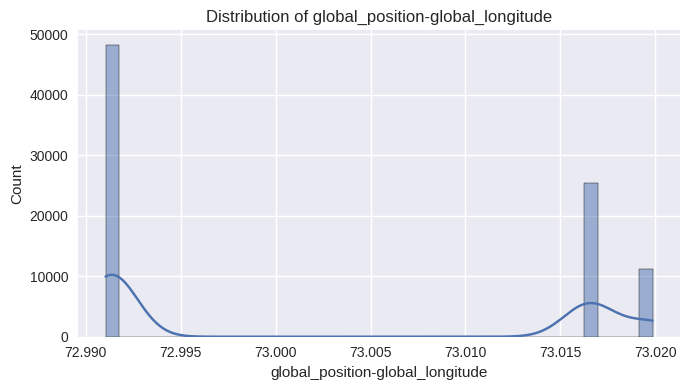

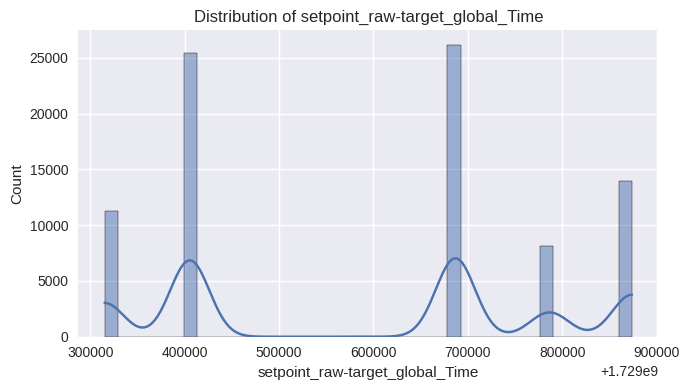

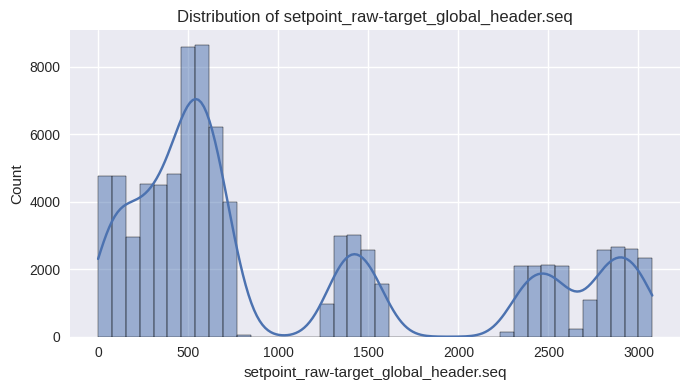

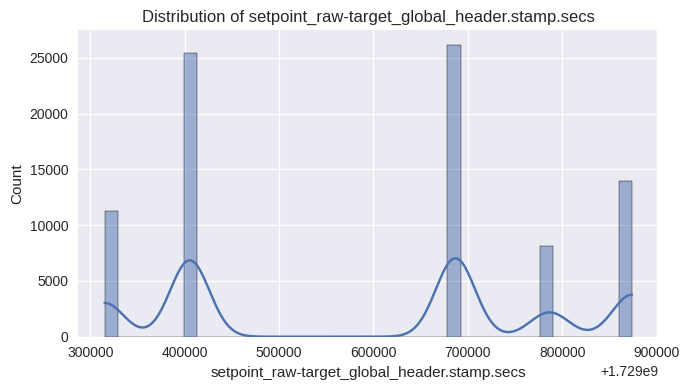

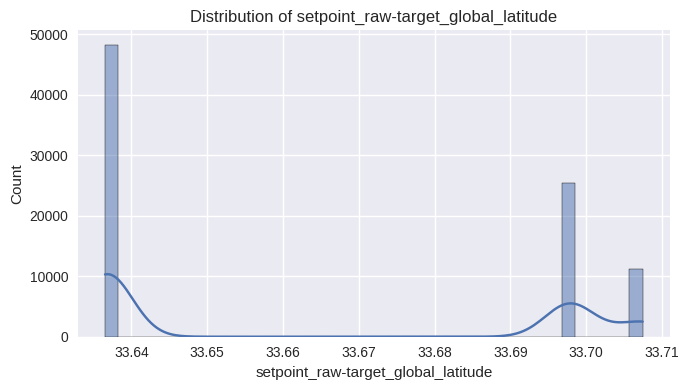

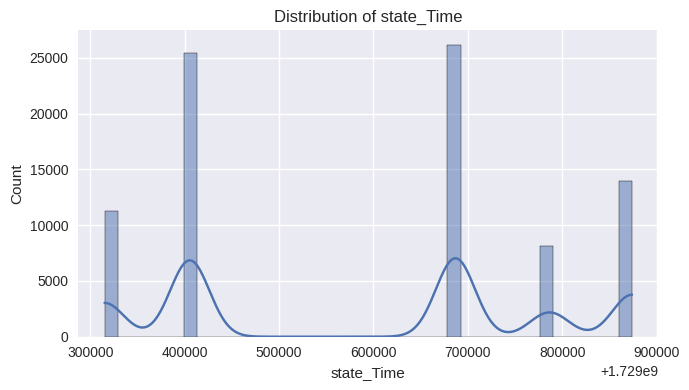

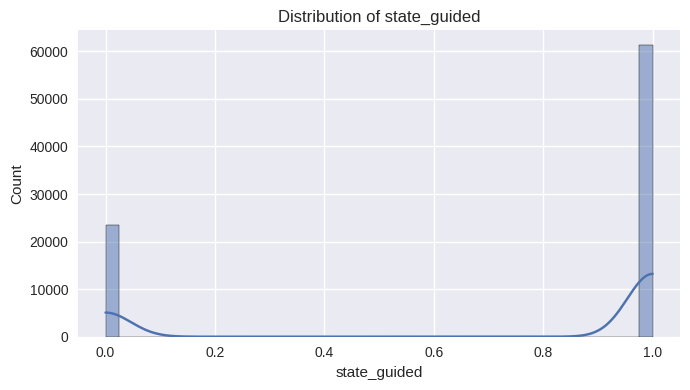

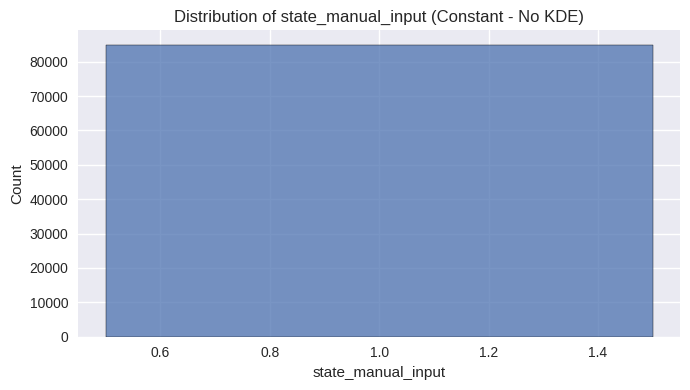

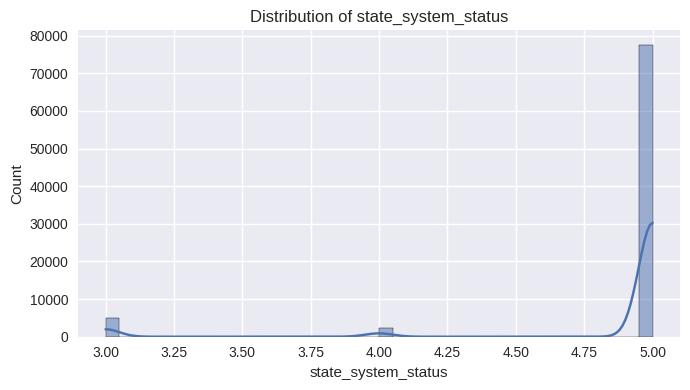

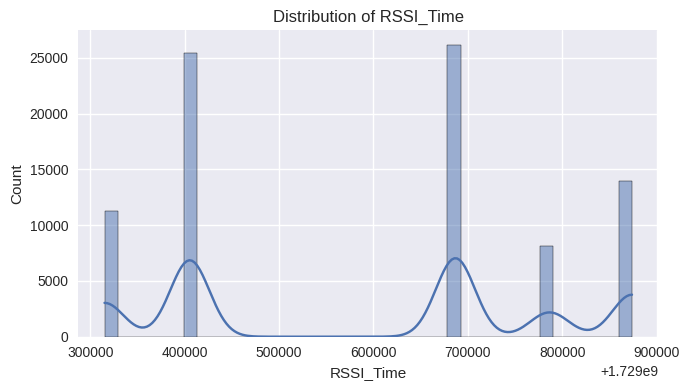

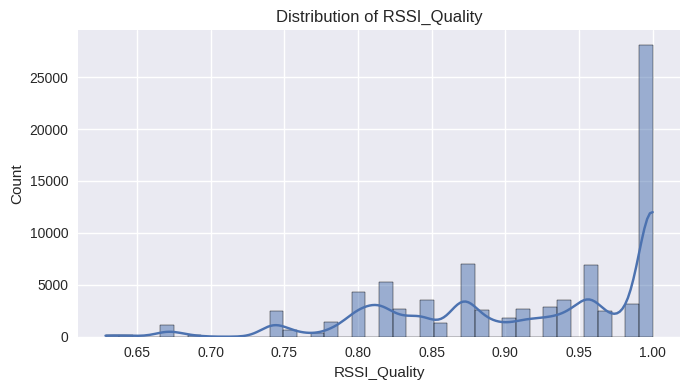

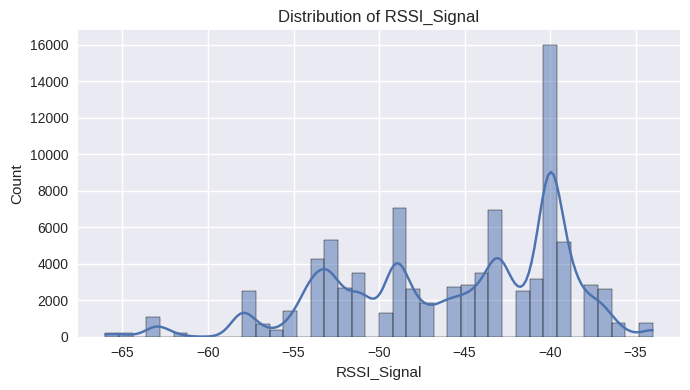

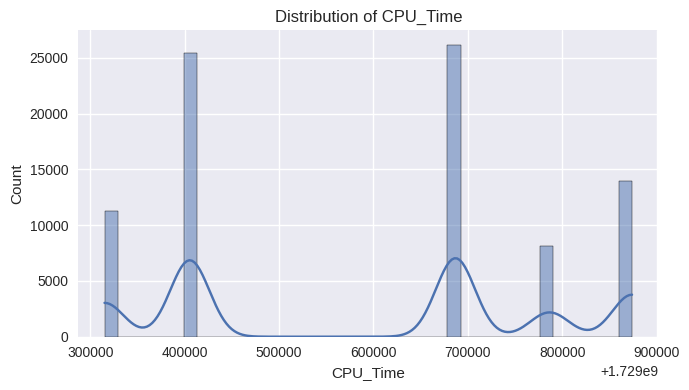

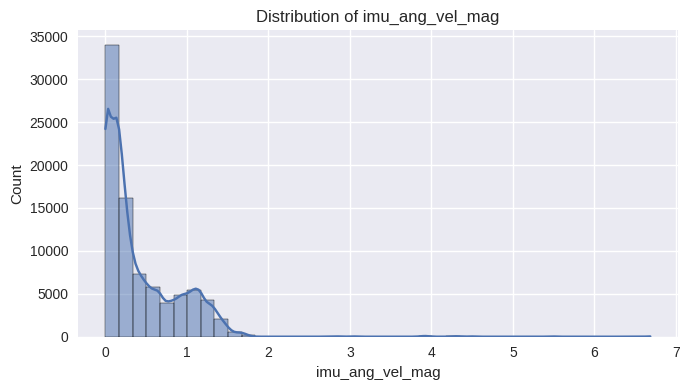

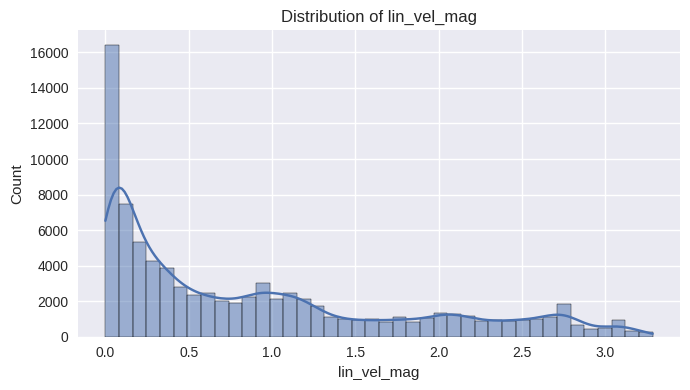

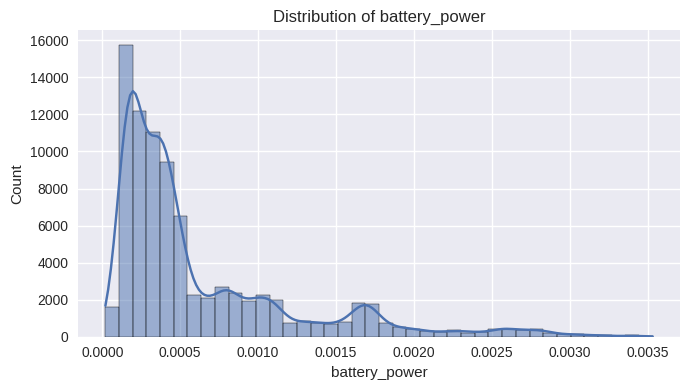

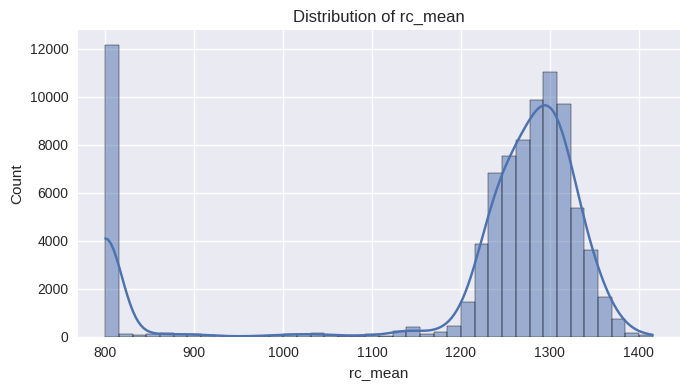

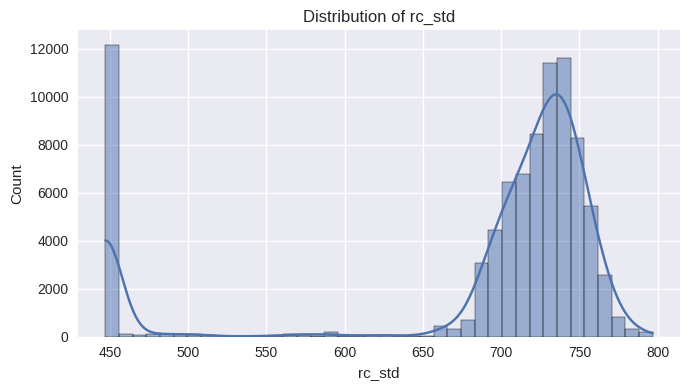

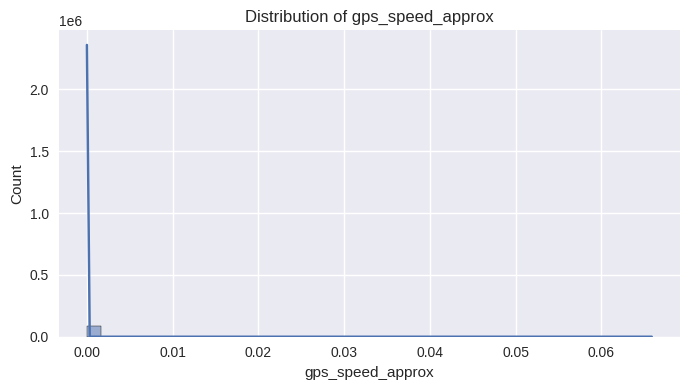

In [ ]:
for col in numeric_cols:
    # After global cleaning, `df_proc[col]` should be clean. Now check for constant columns.
    if df_proc[col].nunique(dropna=True) <= 1:
        print(f"Warning: Column '{col}' contains only one unique value. Plotting histogram without KDE.")
        plt.figure(figsize=(7,4))
        sns.histplot(df_proc[col].dropna(), kde=False, bins=max(1, df_proc[col].dropna().nunique()))
        plt.title(f"Distribution of {col} (Constant - No KDE)")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
        continue

    # Now plot with KDE, as the data should be clean and non-constant
    try:
        plt.figure(figsize=(7,4))
        sns.histplot(df_proc[col], kde=True, bins=40)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        # Catch any unexpected plotting errors, possibly due to edge cases in KDE estimation
        print(f"Unexpected error plotting column '{col}' with KDE: {e}. Plotting histogram without KDE as a fallback.")
        plt.figure(figsize=(7,4))
        sns.histplot(df_proc[col], kde=False, bins=max(1, df_proc[col].nunique())) # Use unique values for bins for constant data
        plt.title(f"Distribution of {col} (Fallback - No KDE)")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

## 2. Boxplots for outlier detection

In [ ]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_proc[numeric_cols])
plt.xticks(rotation=90)
plt.title("Boxplots of Numerical Features (Outlier Detection)")
plt.tight_layout()
plt.show()

## 3. Time series plots (only if index is time)

In [ ]:
# pick only 5 features to avoid clutter
time_features = numeric_cols[:5]

# Sample the DataFrame for plotting to avoid overflow errors with large datasets
sample_size = min(10000, len(df_proc))
df_proc_sampled = df_proc.sample(n=sample_size, random_state=42).sort_index()

plt.figure(figsize=(14,6))
for col in time_features:
    plt.plot(df_proc_sampled.index, df_proc_sampled[col], label=col, alpha=0.9)

plt.legend()
plt.title("Time Series of Selected Features (Sampled)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.tight_layout()
plt.show()

## 4. Correlation heatmap (numeric-only)

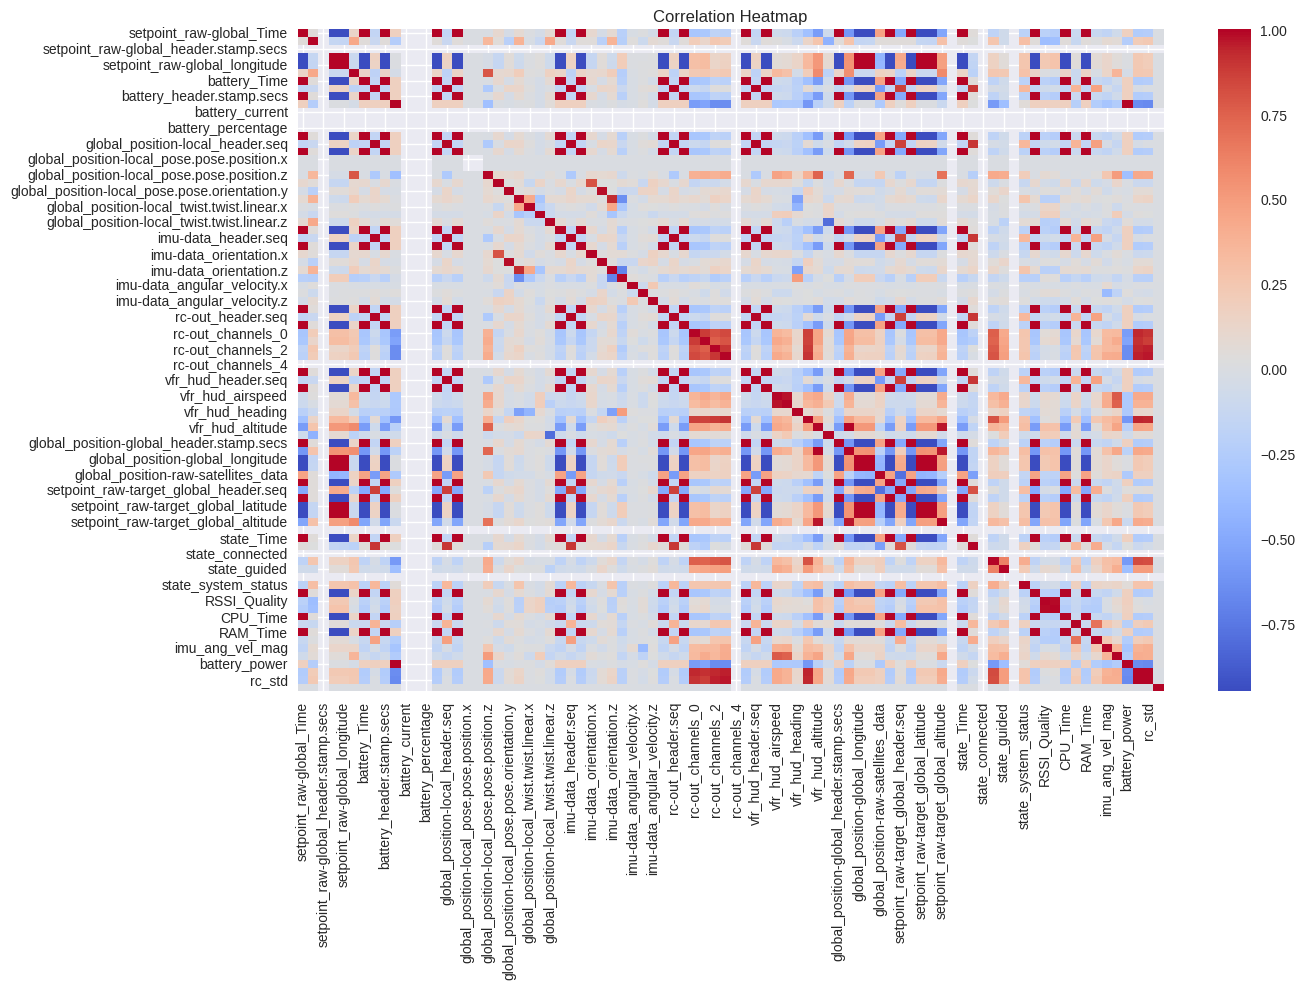

In [ ]:
corr = df_proc[numeric_cols].corr()

plt.figure(figsize=(14,10))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

## 5. Pairplots

Too many plottable columns (76). Selecting the top 14 for visualization.
Caught ValueError during pairplot with KDE: array must not contain infs or NaNs. Trying again with 'hist' for diag_kind.


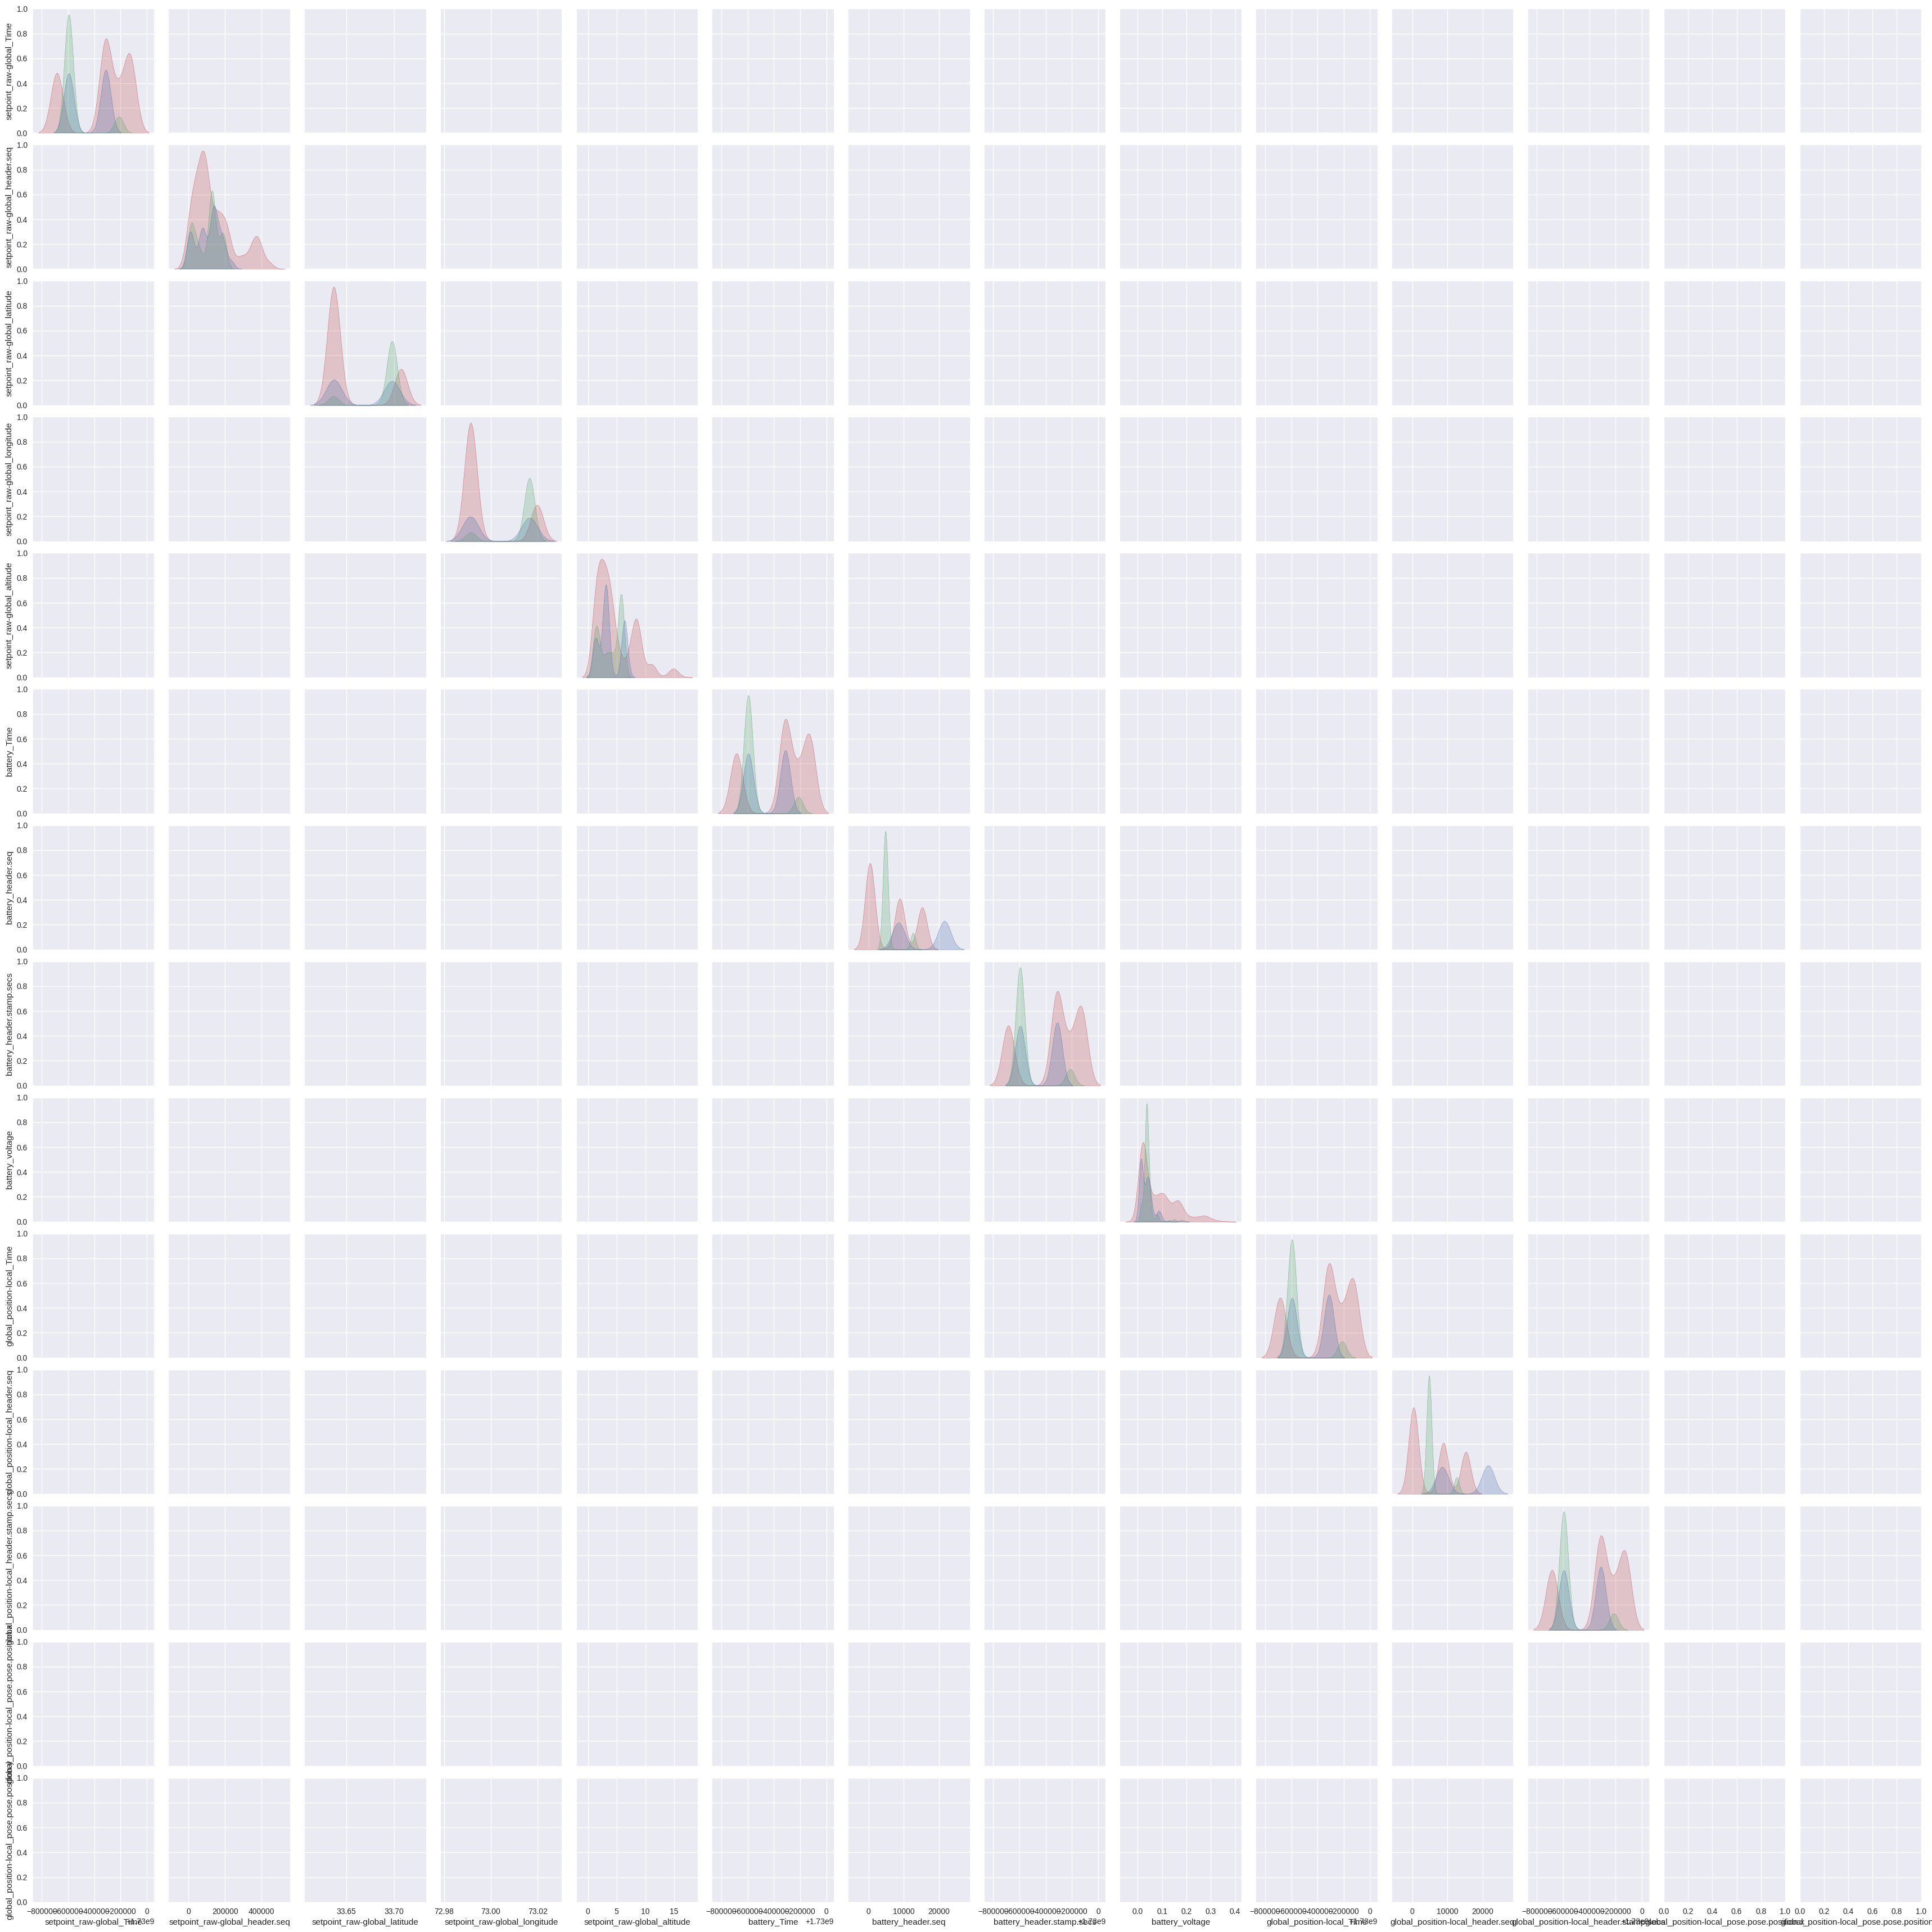

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


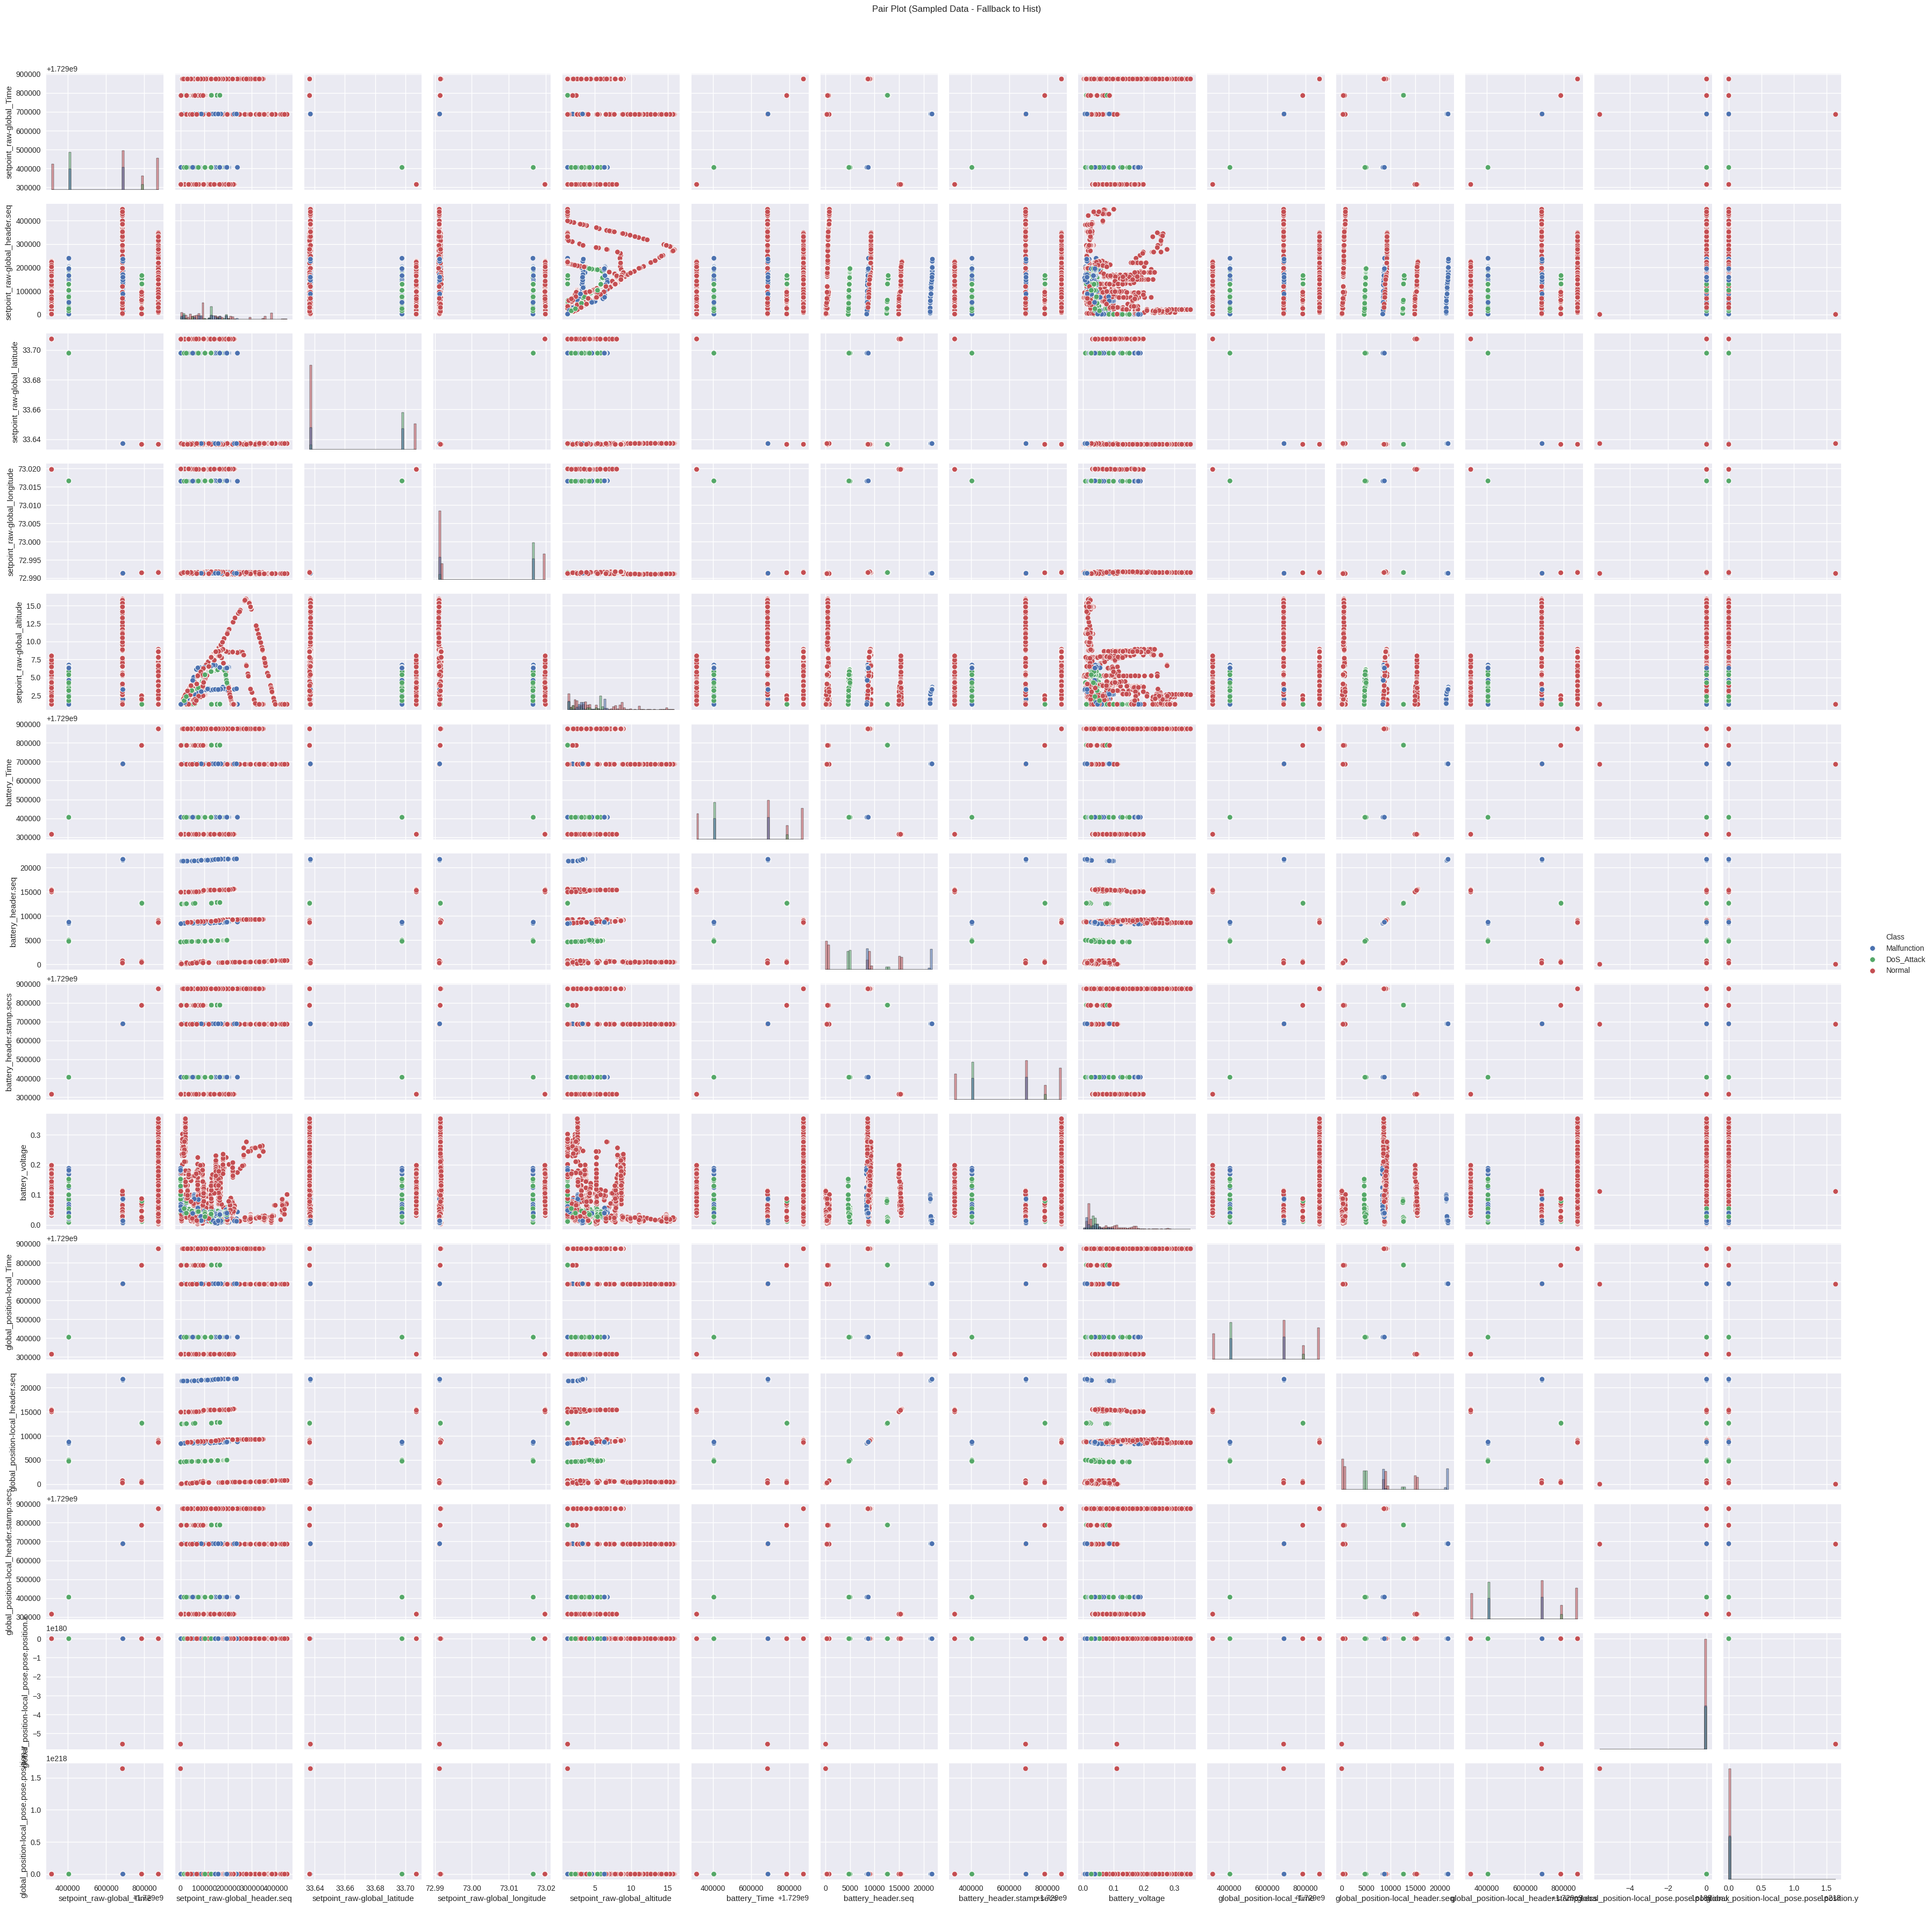

In [ ]:
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Import pandas if not already done

# --- ASSUMPTIONS ---
# df_proc: Your processed DataFrame
# TARGET_COLUMN: The name of your target column (e.g., 'Target')
# numeric_cols: List of all numeric column names
# --- Replace these placeholders with your actual variables if copying directly ---
DF_PROCESSED = df_proc
TARGET_COL_NAME = TARGET_COLUMN

# --- CODE START ---
warnings.filterwarnings("ignore") # Suppress FutureWarnings from seaborn/matplotlib

# Filter out numeric columns that have only one unique value
# Pairplot's KDE will fail on these due to zero variance
plottable_numeric_cols = [col for col in numeric_cols if DF_PROCESSED[col].nunique() > 1]

# Set the desired maximum number of features to plot (14 features + 1 target = 15 columns)
MAX_FEATURES_TO_PLOT = 14

# Ensure there are columns left to plot
if not plottable_numeric_cols:
    print("No plottable numeric columns with sufficient variance found for pairplot.")
elif len(plottable_numeric_cols) > MAX_FEATURES_TO_PLOT:
    print(f"Too many plottable columns ({len(plottable_numeric_cols)}). Selecting the top {MAX_FEATURES_TO_PLOT} for visualization.")
    # Select the first 14 columns
    plottable_numeric_cols = plottable_numeric_cols[:MAX_FEATURES_TO_PLOT]

# Sample the data to avoid performance issues and improve plot readability
sample_df = DF_PROCESSED[plottable_numeric_cols + [TARGET_COL_NAME]].sample(
    # Limiting sample size to 3000 rows or the total size of the DataFrame, whichever is smaller
    n=min(3000, len(DF_PROCESSED)), random_state=42
)

# --- Additional Cleaning for sampled data before pairplot ---
# Check for any remaining non-finite values in sample_df before plotting
non_finite_check_cols = [col for col in plottable_numeric_cols if not np.isfinite(sample_df[col]).all()]
if non_finite_check_cols:
    print(f"DEBUG: Columns in sample_df still containing non-finite values (after sampling): {non_finite_check_cols}")
    # Drop rows with non-finite values in these specific columns for the pairplot
    initial_rows = len(sample_df)
    sample_df = sample_df.dropna(subset=non_finite_check_cols)
    if len(sample_df) < initial_rows:
        print(f"DEBUG: Dropped {initial_rows - len(sample_df)} rows due to non-finite values in sampled data.")


try:
    sns.pairplot(sample_df, hue=TARGET_COL_NAME, diag_kind="kde")
    plt.suptitle("Pair Plot (Sampled Data)", y=1.02)
    plt.savefig('pairplot_kde.png')
    # plt.show() # Use savefig() in Colab, not show()
except ValueError as e:
    print(f"Caught ValueError during pairplot with KDE: {e}. Trying again with 'hist' for diag_kind.")
    # Fallback to diag_kind='hist' if KDE still fails
    sns.pairplot(sample_df, hue=TARGET_COL_NAME, diag_kind="hist", diag_kws={'bins': 50})
    plt.suptitle("Pair Plot (Sampled Data - Fallback to Hist)", y=1.02)
    plt.savefig('pairplot_hist.png')
    # plt.show() # Use savefig() in Colab, not show()

warnings.filterwarnings("default") # Re-enable warnings

## 6. Missing data visualization

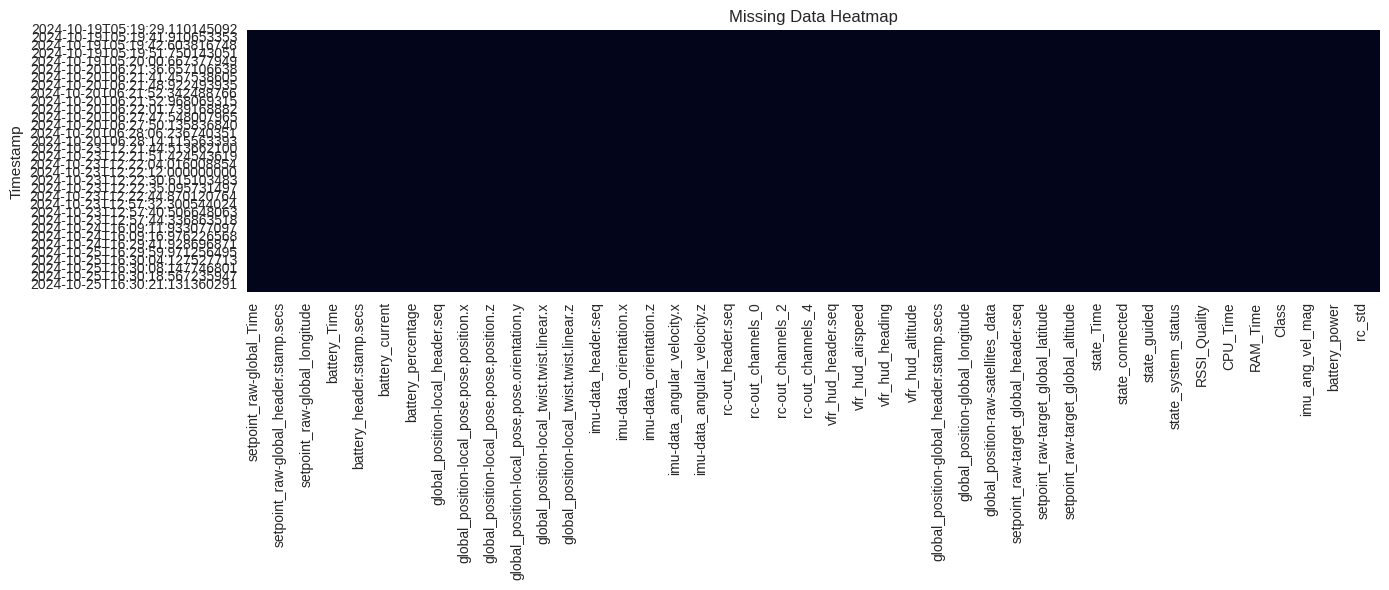

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
plt.figure(figsize=(14,6))
sns.heatmap(df_proc.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.tight_layout()
plt.show()

## Missing bar chart

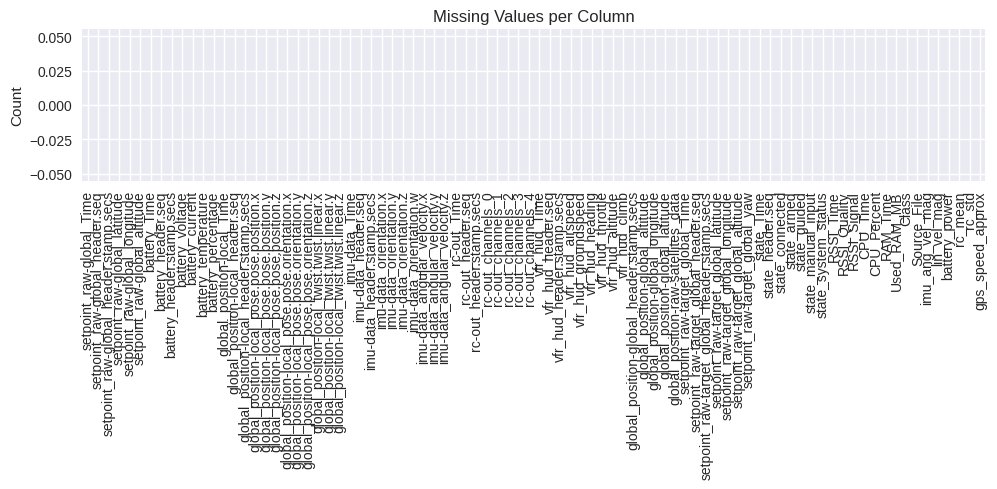

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
plt.figure(figsize=(10,5))
df_proc.isnull().sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Missing Values per Column")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 7. Feature importance (RandomForest quick check)

--- Debugging X before model fit ---
X dtypes: [dtype('float64')]
X has NaNs: 0
X has infs: 0
X max value: 3.4028234663852886e+38 (should be finite)
X min value: -3.4028234663852886e+38 (should be finite)
-----------------------------------


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


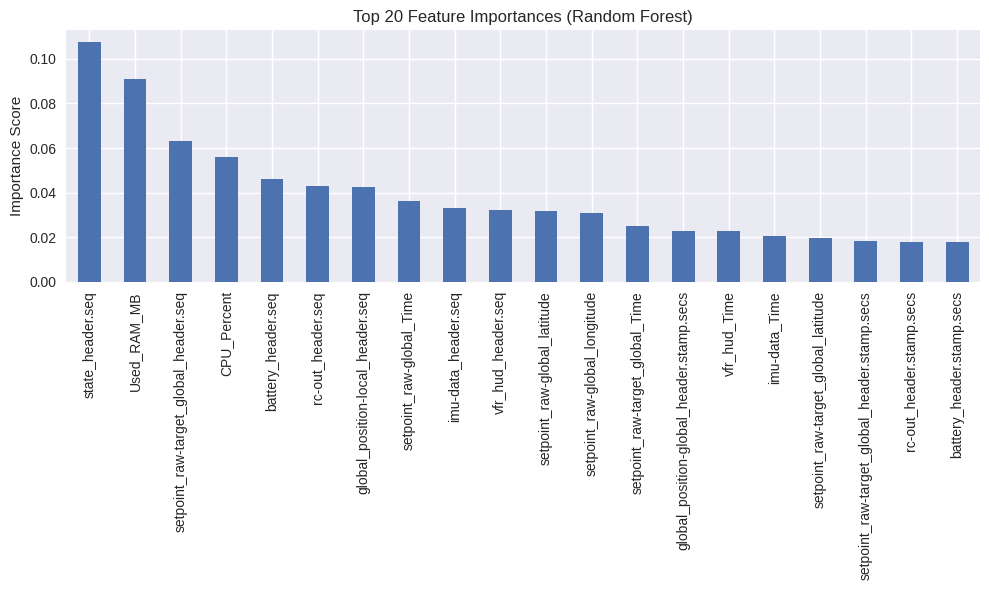

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np # Ensure np is imported

# Drop TARGET_COLUMN and any other non-numeric or meta columns like 'Source_File'
X = df_proc.drop(columns=[TARGET_COLUMN, 'Source_File'])
y = df_proc[TARGET_COLUMN]

# --- Robust numerical cleanup and type enforcement for X ---
# Replace any remaining inf/-inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Impute any NaN values with the median of their respective columns
for col in X.columns:
    if X[col].isnull().any():
        median_val = X[col].median()
        if pd.isna(median_val): # If median itself is NaN (e.g., column is all NaN)
            X[col].fillna(0, inplace=True) # Fallback to 0
        else:
            X[col].fillna(median_val, inplace=True)

# Ensure all numeric columns are of float64 type
X = X.astype(np.float64)

# Clip values to the valid range of float32 to prevent overflow during internal conversion in scikit-learn
float32_info = np.finfo(np.float32)
X = X.clip(lower=float32_info.min, upper=float32_info.max)
# --- End of robust cleanup ---

# --- Debugging: Check X right before fitting ---
print("--- Debugging X before model fit ---")
print(f"X dtypes: {X.dtypes.unique()}")
print(f"X has NaNs: {X.isnull().sum().sum()}")
print(f"X has infs: {np.isinf(X).sum().sum()}")
# Use .max().max() and .min().min() for a single scalar value across all columns
print(f"X max value: {X.max().max()} (should be finite)")
print(f"X min value: {X.min().min()} (should be finite)")
print("-----------------------------------")


model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(20).plot(kind='bar')
plt.title("Top 20 Feature Importances (Random Forest)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

## 8. Class distribution

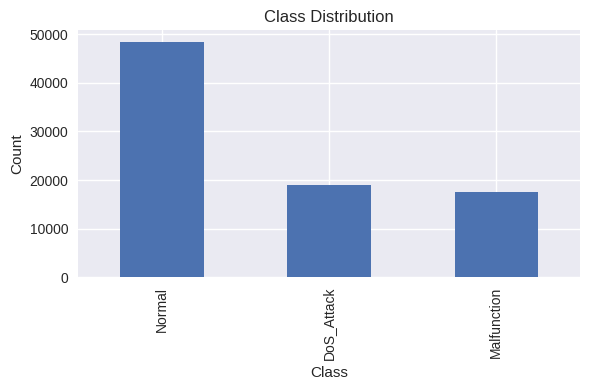

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
plt.figure(figsize=(6,4))
df_proc[TARGET_COLUMN].value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()